#Set up Stuff

This notebook allows you to train and run the EF model presented here (https://ecs193-final-project.herokuapp.com/). In order to run this code, you will need have the cleaned data downloaded. This data is located here: https://drive.google.com/file/d/1ecNmerBZLMQlaWnoyNkE4bZrHPV8gkoL/view?usp=sharing


In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 1.x
except Exception:
  pass

In [11]:
!pip3 install fancyimpute
!pip3 install impyute

In [0]:
import pandas as pd
import sklearn
import keras
import numpy as np
import matplotlib.pyplot as plt
import warnings
import cv2
import math
from time import time
import itertools
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split,KFold
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_curve,average_precision_score,roc_auc_score,roc_curve,recall_score,precision_score,f1_score
from scipy.signal import resample
from collections import Counter
from datetime import datetime
import operator
from datetime import date
from sklearn.metrics import confusion_matrix
from collections import Counter
import fancyimpute
warnings.filterwarnings("ignore")
%matplotlib inline

#Read in the files and understand what's in the files

In [13]:
df_first = pd.read_csv("combined_echo_data_new.csv")
features_picked = ['Pt. ID','Study Date','IVS d, 2D','LA Vol A/L A2C i BSA','LA Vol A/L A4C i BSA',
                   'LA Vol A/L BP i BSA','LV EF, MOD A2C','LV EF, MOD A4C','LV EF, MOD BP',
                   'LV d, 2D','LV s, 2D','RVSP (TR)']

df = df_first[features_picked]  #select only required features
df = df.dropna(how='all', axis=1) #remove empty columns
df = df.dropna(axis=0,how='all',subset = features_picked[2:]) #remove those samples where all the required features are empty.
df = df.dropna(axis = 0,how="all",subset = features_picked[0:1])  #remove those samples where MRN is empty
df.reset_index(inplace=True,drop=True)  #reset and remove the index
df.shape

(93609, 12)

In [14]:
df.head(10)

,Pt. ID,Study Date,"IVS d, 2D",LA Vol A/L A2C i BSA,LA Vol A/L A4C i BSA,LA Vol A/L BP i BSA,"LV EF, MOD A2C","LV EF, MOD A4C","LV EF, MOD BP","LV d, 2D","LV s, 2D",RVSP (TR)
0,621830,2011-08-26 00:00:00,1.67,NaN,NaN,NaN,74.228030,74.068014,74.522299,4.98,2.47,43.836900
1,8211873,2011-08-26 00:00:00,0.81,NaN,NaN,NaN,60.911188,58.886563,58.658488,4.34,2.87,23.250000
2,1604126,2011-08-26 00:00:00,1.15,NaN,NaN,NaN,NaN,NaN,NaN,3.50,2.47,32.637136
3,1138796,2011-08-26 00:00:00,1.00,NaN,NaN,NaN,NaN,66.487936,NaN,2.57,1.63,32.075378
4,1166649,2011-08-26 00:00:00,1.27,NaN,NaN,NaN,NaN,72.222222,NaN,3.94,1.95,36.918976
5,1553602,2011-08-26 00:00:00,1.32,NaN,NaN,NaN,NaN,63.945578,NaN,4.36,2.65,NaN
6,772382,2011-08-26 00:00:00,1.28,NaN,NaN,NaN,NaN,NaN,NaN,3.26,2.36,NaN
7,190563,2011-08-26 00:00:00,1.26,NaN,NaN,NaN,79.290564,71.259471,75.216268,5.76,4.02,26.554844
8,1770688,2011-08-26 00:00:00,1.27,NaN,NaN,NaN,NaN,NaN,NaN,3.82,2.27,19.429511
9,2098292,2011-08-26 00:00:00,1.13,NaN,NaN,NaN,NaN,68.644068,NaN,4.50,2.94,26.425600


In [15]:
df.isna().sum() #check empty

Pt. ID                      0
Study Date                  0
IVS d, 2D               10557
LA Vol A/L A2C i BSA    54252
LA Vol A/L A4C i BSA    48235
LA Vol A/L BP i BSA     54519
LV EF, MOD A2C          65429
LV EF, MOD A4C          39079
LV EF, MOD BP           66214
LV d, 2D                10885
LV s, 2D                12671
RVSP (TR)               24127
dtype: int64

#Combine all the 3 channels into one

In [0]:
#replace the 3 channels values with the average across the channels
def ef_select_avg():
  vol,ef = [],[]  #created new cols
  for index, record in df.iterrows():
    volume_A4C = record["LA Vol A/L A4C i BSA"]
    volume_A2C = record["LA Vol A/L A2C i BSA"]
    volume_BP =  record["LA Vol A/L BP i BSA"]
    ef_A4C = record["LV EF, MOD A4C"]
    ef_A2C = record["LV EF, MOD A2C"]
    ef_BP = record["LV EF, MOD BP"]
    #For volumes
    #pick by computing average
    temp = 0
    count = 0
    if not np.isnan(volume_A4C):
      temp = temp + volume_A4C
      count = count + 1
    if not np.isnan(volume_A2C):
      temp = temp + volume_A2C
      count = count + 1
    if not np.isnan(volume_BP):
      temp = temp + volume_BP
      count = count + 1
    if count > 0:
      vol.append(temp/count)
    else:
      vol.append(float("nan"))
    
    #do the same for EF

    temp = 0
    count = 0
    if not np.isnan(ef_A4C):
      temp = temp + ef_A4C
      count = count + 1
    if not np.isnan(ef_A2C):
      temp = temp + ef_A2C
      count = count + 1
    if not np.isnan(ef_BP):
      temp = temp + ef_BP
      count = count + 1
    if count > 0:
      ef.append(temp/count)
    else:
      ef.append(float("nan"))
  df["LA Vol A/L Volume"] = vol #new column for Volume added
  df["Ejection_Fraction"] = ef  #new column for EF added

In [0]:
def ef_select_dup(df):
  #if more than one non-null channel exists, duplicate the sample
  df_new = pd.DataFrame(columns = df.columns)
  vol,ef = [],[]  #created new cols
  for index, record in df.iterrows():
    volume_A4C = record["LA Vol A/L A4C i BSA"]
    volume_A2C = record["LA Vol A/L A2C i BSA"]
    volume_BP =  record["LA Vol A/L BP i BSA"]
    ef_A4C = record["LV EF, MOD A4C"]
    ef_A2C = record["LV EF, MOD A2C"]
    ef_BP = record["LV EF, MOD BP"]
    #duplicate records if more than one EF is present

    if not np.isnan(ef_A4C):
      df_new = df_new.append(record,ignore_index = True)
      ef.append(ef_A4C)
      if not np.isnan(volume_A4C):
        vol.append(volume_A4C)
      else:
        vol.append(float("nan"))
    
    if not np.isnan(ef_A2C):
      df_new = df_new.append(record,ignore_index = True)
      ef.append(ef_A2C)
      if not np.isnan(volume_A2C):
        vol.append(volume_A2C)
      else:
        vol.append(float("nan"))
    
    if not np.isnan(ef_BP):
      df_new = df_new.append(record,ignore_index = True)
      ef.append(ef_BP)
      if not np.isnan(volume_BP):
        vol.append(volume_BP)
      else:
        vol.append(float("nan"))
  df_new["LA Vol A/L Volume"] = vol #new column for Volume added
  df_new["Ejection_Fraction"] = ef  #new column for EF added
  return df_new #replace old dataset with augmented dataset

In [18]:
ef_select_avg()
#df = ef_select_dup(df)
df = df.drop(["LA Vol A/L A4C i BSA","LA Vol A/L A2C i BSA","LA Vol A/L BP i BSA","LV EF, MOD A4C","LV EF, MOD A2C","LV EF, MOD BP"],axis=1) #drop these obsolete cols
df.shape

(93609, 8)

In [19]:
df.head(10)

,Pt. ID,Study Date,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,621830,2011-08-26 00:00:00,1.67,4.98,2.47,43.836900,NaN,74.272781
1,8211873,2011-08-26 00:00:00,0.81,4.34,2.87,23.250000,NaN,59.485413
2,1604126,2011-08-26 00:00:00,1.15,3.50,2.47,32.637136,NaN,NaN
3,1138796,2011-08-26 00:00:00,1.00,2.57,1.63,32.075378,NaN,66.487936
4,1166649,2011-08-26 00:00:00,1.27,3.94,1.95,36.918976,NaN,72.222222
5,1553602,2011-08-26 00:00:00,1.32,4.36,2.65,NaN,NaN,63.945578
6,772382,2011-08-26 00:00:00,1.28,3.26,2.36,NaN,NaN,NaN
7,190563,2011-08-26 00:00:00,1.26,5.76,4.02,26.554844,NaN,75.255434
8,1770688,2011-08-26 00:00:00,1.27,3.82,2.27,19.429511,NaN,NaN
9,2098292,2011-08-26 00:00:00,1.13,4.50,2.94,26.425600,NaN,68.644068


In [20]:
df = df.dropna(axis = 0, how="all",subset=["Ejection_Fraction"])  #drop all the Missing EF values
df.shape

(54674, 8)

In [21]:
df.head(10)

,Pt. ID,Study Date,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,621830,2011-08-26 00:00:00,1.67,4.98,2.47,43.836900,NaN,74.272781
1,8211873,2011-08-26 00:00:00,0.81,4.34,2.87,23.250000,NaN,59.485413
3,1138796,2011-08-26 00:00:00,1.00,2.57,1.63,32.075378,NaN,66.487936
4,1166649,2011-08-26 00:00:00,1.27,3.94,1.95,36.918976,NaN,72.222222
5,1553602,2011-08-26 00:00:00,1.32,4.36,2.65,NaN,NaN,63.945578
7,190563,2011-08-26 00:00:00,1.26,5.76,4.02,26.554844,NaN,75.255434
9,2098292,2011-08-26 00:00:00,1.13,4.50,2.94,26.425600,NaN,68.644068
11,875891,2011-08-26 00:00:00,NaN,NaN,NaN,NaN,NaN,8.695652
13,2098323,2011-08-26 00:00:00,NaN,NaN,NaN,NaN,NaN,19.893166
16,2043226,2011-08-26 00:00:00,1.23,5.35,4.43,NaN,NaN,30.215426


In [22]:
df.isna().sum() #look at the reduced number of null values

Pt. ID                   0
Study Date               0
IVS d, 2D             3488
LV d, 2D              3464
LV s, 2D              4418
RVSP (TR)            13423
LA Vol A/L Volume    20669
Ejection_Fraction        0
dtype: int64

#Outlier Detection

In [0]:
def plot_var(var,col):
  non_null = var.dropna()
  min_val,max_val = min(non_null),max(non_null)
  plt.figure()
  plt.title("Frequency plot for the " + str(col) + f" ;Min = {min_val} ; Max = {max_val}")
  plt.xlabel(col)
  plt.ylabel("Frequency distribution")
  plt.hist(var,bins = 100)

Before Outlier Removal


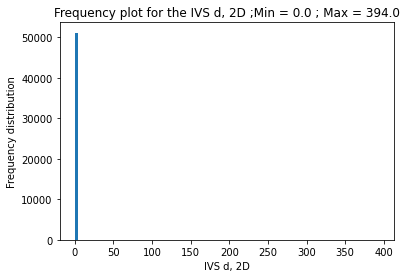

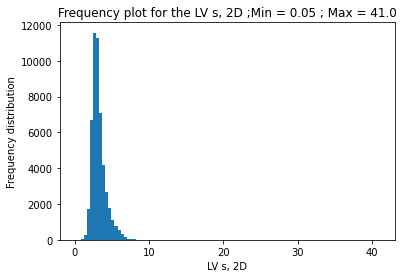

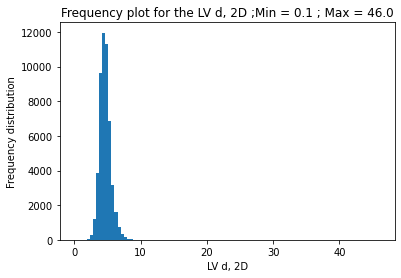

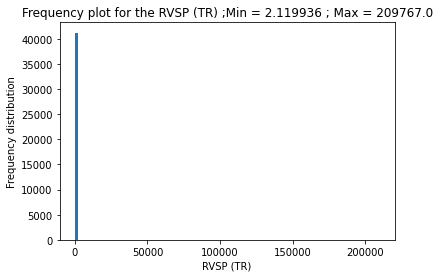

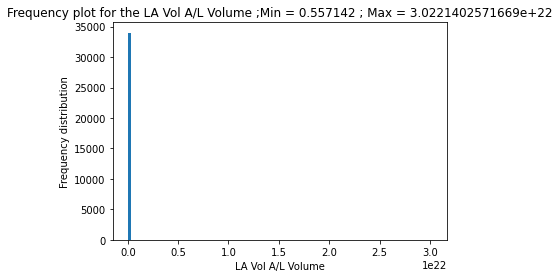

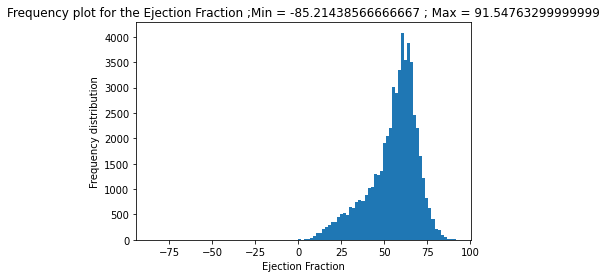

In [24]:
#graph the features now: see the outlier presence in the distribution
print("Before Outlier Removal")
plot_var(df['IVS d, 2D'],"IVS d, 2D")
plot_var(df['LV s, 2D'],"LV s, 2D")
plot_var(df['LV d, 2D'],"LV d, 2D")
plot_var(df["RVSP (TR)"],"RVSP (TR)")
plot_var(df["LA Vol A/L Volume"],"LA Vol A/L Volume")
plot_var(df["Ejection_Fraction"],"Ejection Fraction")

In [25]:
#identify the presence of the outliers
for col in df.columns[2:]:
  print(df[col].value_counts().sort_index())

0.000      4
0.080      1
0.085      1
0.100      1
0.103      1
          ..
12.000     2
15.000     1
16.000     1
22.000     1
394.000    1
Name: IVS d, 2D, Length: 2311, dtype: int64
0.100000     1
0.501009     1
0.690000     1
1.150000     1
1.840000     1
            ..
9.760000     1
10.300000    1
40.000000    1
45.000000    1
46.000000    1
Name: LV d, 2D, Length: 2565, dtype: int64
0.050000     1
0.800000     1
0.942000     1
0.943603     1
0.946000     1
            ..
8.880000     2
9.100000     1
9.220000     1
9.300000     1
41.000000    1
Name: LV s, 2D, Length: 2413, dtype: int64
2.119936         1
2.650384         1
3.000000         2
3.407716         1
3.610000         1
                ..
2124.000000      1
2722.410000      1
3603.000000      1
18511.000000     1
209767.000000    1
Name: RVSP (TR), Length: 9427, dtype: int64
5.571420e-01    1
7.612050e-01    1
2.253735e+00    1
2.994159e+00    1
3.051090e+00    1
               ..
5.542517e+02    1
1.202024e+03    1


In [0]:
#for these cols; these vals are the outliers
#IVS d, 2D >5 ; LV d, 2D > 10 ; LV s, 2D > 10 ; RVSP (TR) > 125; LA Vol A/L Volume > 200; Ejection_Fraction <= 0
#let's get rid of these outliers first
ind = df[df['Ejection_Fraction'] <= 0].index.tolist() + df[df['IVS d, 2D'] > 5].index.tolist() 
ind = ind + df[df['LV d, 2D'] > 10].index.tolist() + df[df['LV s, 2D'] > 10].index.tolist() 
ind += df[df['RVSP (TR)'] > 125].index.tolist() + df[df['LA Vol A/L Volume'] > 200].index.tolist()
df_remd = df.drop(ind,axis=0)

In [27]:
df_remd.shape

(54607, 8)

After Outlier Removal


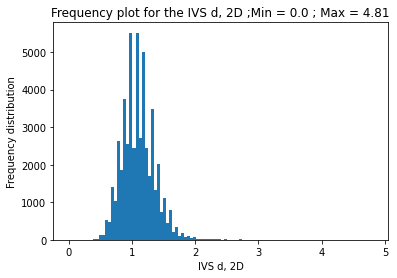

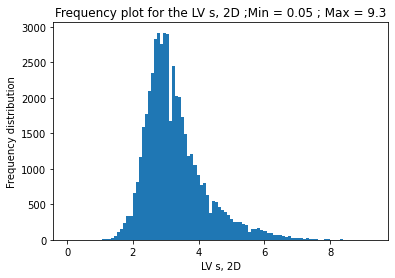

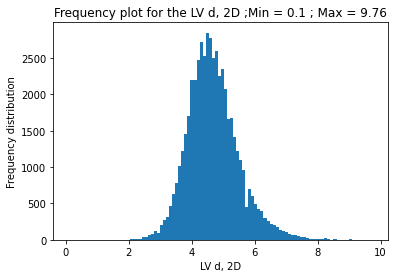

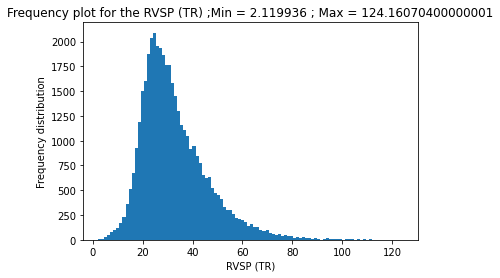

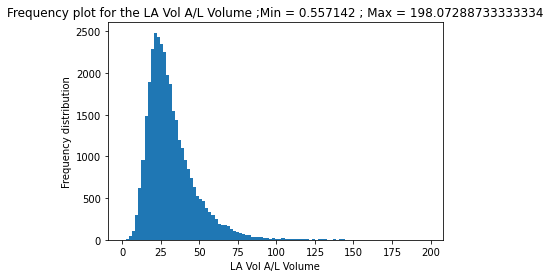

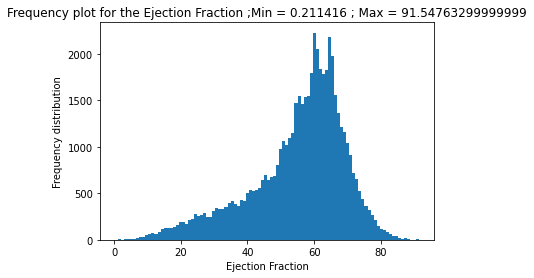

In [28]:
#check the distributions now ; after outlier removal
print("After Outlier Removal")
plot_var(df_remd['IVS d, 2D'],"IVS d, 2D")
plot_var(df_remd['LV s, 2D'],"LV s, 2D")
plot_var(df_remd['LV d, 2D'],"LV d, 2D")
plot_var(df_remd["RVSP (TR)"],"RVSP (TR)")
plot_var(df_remd["LA Vol A/L Volume"],"LA Vol A/L Volume")
plot_var(df_remd["Ejection_Fraction"],"Ejection Fraction")

In [29]:
#check the presence of outliers if any; very few now
for col in df.columns[2:]:
  print(df_remd[col].value_counts().sort_index())

0.000000    4
0.080000    1
0.085000    1
0.100000    1
0.103000    1
           ..
3.350000    1
3.553500    1
3.600000    1
3.724668    1
4.810000    1
Name: IVS d, 2D, Length: 2295, dtype: int64
0.10    1
0.69    1
1.15    1
1.84    1
1.90    1
       ..
9.40    1
9.43    1
9.50    1
9.71    1
9.76    1
Name: LV d, 2D, Length: 2552, dtype: int64
0.050000    1
0.800000    1
0.942000    1
0.943603    1
0.946000    1
           ..
8.730000    1
8.800000    1
8.880000    2
9.220000    1
9.300000    1
Name: LV s, 2D, Length: 2404, dtype: int64
2.119936      1
2.650384      1
3.000000      2
3.407716      1
3.610000      1
             ..
117.472900    1
117.490000    1
121.858447    1
122.784400    1
124.160704    1
Name: RVSP (TR), Length: 9396, dtype: int64
0.557142      1
0.761205      1
2.253735      1
2.994159      1
3.051090      1
             ..
183.456350    1
183.693305    1
184.610422    1
196.599081    1
198.072887    1
Name: LA Vol A/L Volume, Length: 33861, dtype: int64
0.2

# Data Augmentation

In [0]:
#aug = pd.DataFrame(columns = df_remd.columns)
def weightdup(df_remd):#duplicate samples with low ef, depending how low the ef is
  for index, record in df_remd.iterrows():
    if record["Ejection_Fraction"] < 50:
      aug = aug.append(record)
    if record["Ejection_Fraction"] < 35:
      aug = aug.append(record)
    if record["Ejection_Fraction"] < 20:
      aug = aug.append(record)
#weightdup(df_remd)
#df_remd = df_remd.append(aug,ignore_index = True)
#df_remd = df_remd.sample(frac=1).reset_index(drop=True)

In [0]:
def undersamp(df):#remove samples with high ef so that the number of samples with high ef and low ef is the same
  high = pd.DataFrame(columns = df_remd.columns)
  low = pd.DataFrame(columns = df_remd.columns)
  for index, record in df_remd.iterrows():
    if record["Ejection_Fraction"] < 35:
      low = low.append(record)
    else:
      high = high.append(record)
  temp = high.sample(n=len(low.index), random_state=2)
  low = low.append(temp,ignore_index = True)
  low = low.sample(frac=1).reset_index(drop=True)
  return low
df_backup = df_remd
df_remd = undersamp(df_remd)

In [0]:
def TenOver(df_remd): #duplicate all samples with low ef 10 times
  aug = pd.DataFrame(columns = df_remd.columns)
  for index, record in df_remd.iterrows():
    if record["Ejection_Fraction"] < 35:
      for j in range(10):
        aug = aug.append(record)
#TenOver(df_remd)
#df_remd = df_remd.append(aug,ignore_index = True)
#df_remd = df_remd.sample(frac=1).reset_index(drop=True)

In [33]:
df_remd.head(10)

,Pt. ID,Study Date,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,7207336,2016-11-17 00:00:00,NaN,6.47,6.050,47.262400,NaN,15.620880
1,2125776,2017-05-17 00:00:00,0.900,6.56,5.560,45.177600,48.690128,30.349615
2,1918995,2010-05-10 00:00:00,0.800,4.66,2.490,43.100844,NaN,55.025044
3,1539299,2016-03-26 00:00:00,0.864,6.70,5.200,NaN,40.665372,27.272727
4,204501,2013-10-09 00:00:00,1.200,4.10,2.500,30.457600,NaN,65.277778
5,7077684,2018-03-07 00:00:00,1.310,4.81,3.110,31.419600,21.435557,71.002423
6,1320634,2011-09-15 00:00:00,1.000,4.60,2.900,58.552100,NaN,72.197329
7,1009859,2012-12-15 00:00:00,1.100,5.60,5.100,58.552100,NaN,26.058682
8,1549102,2017-06-16 00:00:00,1.360,4.70,3.575,45.250000,44.605335,34.589041
9,1499035,2011-01-14 00:00:00,0.940,5.49,5.170,36.832400,NaN,23.800213


In [34]:
df_remd.shape

(11764, 8)

After Outlier Removal


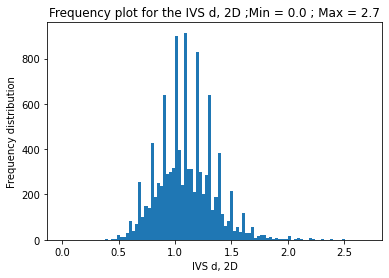

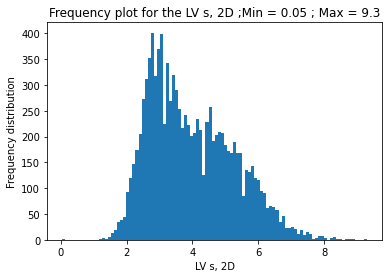

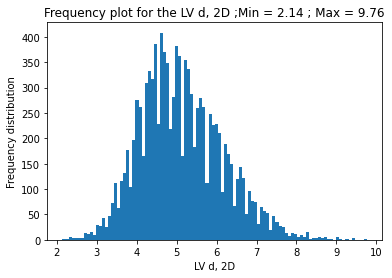

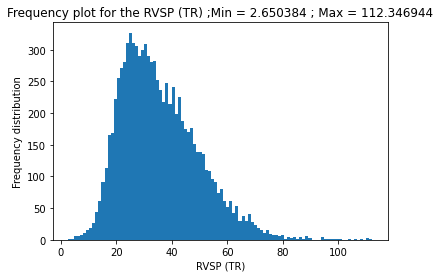

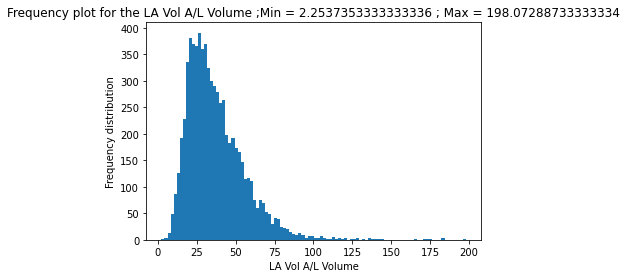

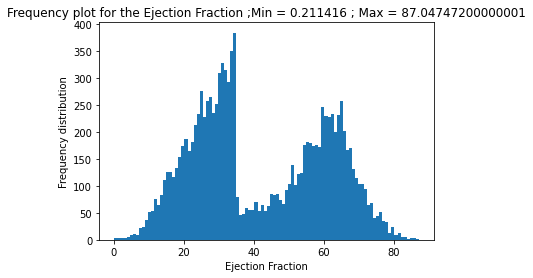

In [35]:
#check the distributions now ; after data augmentation
print("After Outlier Removal")
plot_var(df_remd['IVS d, 2D'],"IVS d, 2D")
plot_var(df_remd['LV s, 2D'],"LV s, 2D")
plot_var(df_remd['LV d, 2D'],"LV d, 2D")
plot_var(df_remd["RVSP (TR)"],"RVSP (TR)")
plot_var(df_remd["LA Vol A/L Volume"],"LA Vol A/L Volume")
plot_var(df_remd["Ejection_Fraction"],"Ejection Fraction")

#Missing Value Imputation

In [36]:
df_remd.shape

(11764, 8)

In [37]:
df_backup.reset_index(drop= True,inplace=True)
df_remd.reset_index(drop= True,inplace=True)
df_remd.head(10)

,Pt. ID,Study Date,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,7207336,2016-11-17 00:00:00,NaN,6.47,6.050,47.262400,NaN,15.620880
1,2125776,2017-05-17 00:00:00,0.900,6.56,5.560,45.177600,48.690128,30.349615
2,1918995,2010-05-10 00:00:00,0.800,4.66,2.490,43.100844,NaN,55.025044
3,1539299,2016-03-26 00:00:00,0.864,6.70,5.200,NaN,40.665372,27.272727
4,204501,2013-10-09 00:00:00,1.200,4.10,2.500,30.457600,NaN,65.277778
5,7077684,2018-03-07 00:00:00,1.310,4.81,3.110,31.419600,21.435557,71.002423
6,1320634,2011-09-15 00:00:00,1.000,4.60,2.900,58.552100,NaN,72.197329
7,1009859,2012-12-15 00:00:00,1.100,5.60,5.100,58.552100,NaN,26.058682
8,1549102,2017-06-16 00:00:00,1.360,4.70,3.575,45.250000,44.605335,34.589041
9,1499035,2011-01-14 00:00:00,0.940,5.49,5.170,36.832400,NaN,23.800213


In [38]:
missing = dict(df_remd.isna().sum()) #look at the reduced number of null values
print("Missing value count as a percentage")
total = df_remd.shape[0]
for k,v in missing.items():
  print("%s: %.2f%%"%(k,int(v)*100/total))

Missing value count as a percentage
Pt. ID: 0.00%
Study Date: 0.00%
IVS d, 2D: 8.13%
LV d, 2D: 7.85%
LV s, 2D: 11.03%
RVSP (TR): 23.05%
LA Vol A/L Volume: 39.78%
Ejection_Fraction: 0.00%


In [39]:
len(df_remd['Pt. ID'].unique().tolist()) #number of unique patients

8822


# Let's try a variety of methods now:
1. MICE
2. Zero/Constant Imputation
3. EM
4. SoftImpute implementation (TODO)
5. IterativeSVD (TODO)
6. NuclearNormMinimization (TODO)
7. The method based on the paper I read (on Google Drive) (TODO)
8. KNN Implementation (TODO)


In [40]:
X_backup,y_backup = df_backup[df_backup.columns.to_list()[2:-1]],df_backup[df_backup.columns.to_list()[-1]]
X,y = df_remd[df_remd.columns.to_list()[2:-1]],df_remd[df_remd.columns.to_list()[-1]] #get the features and outputs
(y<35.0).value_counts() #count of the output distribution

True     5882
False    5882
Name: Ejection_Fraction, dtype: int64

In [41]:
X.head(10)

,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume
0,NaN,6.47,6.050,47.262400,NaN
1,0.900,6.56,5.560,45.177600,48.690128
2,0.800,4.66,2.490,43.100844,NaN
3,0.864,6.70,5.200,NaN,40.665372
4,1.200,4.10,2.500,30.457600,NaN
5,1.310,4.81,3.110,31.419600,21.435557
6,1.000,4.60,2.900,58.552100,NaN
7,1.100,5.60,5.100,58.552100,NaN
8,1.360,4.70,3.575,45.250000,44.605335
9,0.940,5.49,5.170,36.832400,NaN


In [42]:
X.shape

(11764, 5)

In [0]:
X_feat_backup = X_backup.values
X_feat = X.values #get the array version of features

In [0]:
from impyute.imputation.cs import mice,em

In [45]:
start = time()
X_fill_MICE = mice(X_feat) #MICE imputation for missing values
X_MICE_backup = mice(X_feat_backup)
end = time()
print("MICE over: %.2f mins"%((end - start)/60.00))

MICE over: 6.22 mins


In [46]:
start = time()
X_fill_EM = em(X_feat) #EM imputation for missing values
end = time()
print("EM over: %.2f mins"%((end - start)/60.00))

EM over: 0.26 mins


In [47]:
start = time()
X_fill_Zero = np.nan_to_num(X_feat) #fill empty with zeros
X_Zero_backup = np.nan_to_num(X_feat_backup)
end = time()
print("Zero filling over: %.2f mins"%((end - start)/60.00))

Zero filling over: 0.00 mins


In [48]:
from fancyimpute import IterativeSVD
start = time()
X_fill_svd = IterativeSVD(4).fit_transform(X_feat) #IterativeSVD imputation for missing values
end = time()
print("IterativeSVD filling over: %.2f mins"%((end - start)/60.00))

[IterativeSVD] Iter 1: observed MAE=4.271328
[IterativeSVD] Iter 2: observed MAE=0.886606
[IterativeSVD] Iter 3: observed MAE=0.076476
[IterativeSVD] Iter 4: observed MAE=0.076737
IterativeSVD filling over: 0.00 mins


In [49]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
start = time()
i_imp = IterativeImputer(random_state=0)
i_imp.fit(X_feat)
X_i_imp = i_imp.transform(X_feat) #IterativeSVD imputation for missing values
end = time()
print("IterativeImputer filling over: %.2f mins"%((end - start)/60.00))

IterativeImputer filling over: 0.01 mins


In [0]:
#let's reassemble the imputed data into seperate Datasets now
df_mice = pd.DataFrame(X_fill_MICE,columns=df_remd.columns.to_list()[2:-1])
df_em = pd.DataFrame(X_fill_EM,columns=df_remd.columns.to_list()[2:-1])
df_zero = pd.DataFrame(X_fill_Zero,columns=df_remd.columns.to_list()[2:-1])
df_svd = pd.DataFrame(X_fill_svd,columns=df_remd.columns.to_list()[2:-1])
df_iimp = pd.DataFrame(X_i_imp,columns=df_remd.columns.to_list()[2:-1])

df_backup_new = pd.DataFrame(X_MICE_backup,columns=df_backup.columns.to_list()[2:-1])

ptd_id = df_remd['Pt. ID']

df_mice.insert(0,'Pt. ID',ptd_id)
df_mice["Ejection_Fraction"] = y

df_em.insert(0,'Pt. ID',ptd_id)
df_em["Ejection_Fraction"] = y

df_zero.insert(0,'Pt. ID',ptd_id)
df_zero["Ejection_Fraction"] = y

df_svd.insert(0,'Pt. ID',ptd_id)
df_svd["Ejection_Fraction"] = y

df_iimp.insert(0,'Pt. ID',ptd_id)
df_iimp["Ejection_Fraction"] = y

df_backup_new.insert(0,'Pt. ID',df_backup['Pt. ID'])
df_backup_new["Ejection_Fraction"] = y_backup

In [51]:
df_mice.head(10)

,Pt. ID,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,7207336,1.090055,6.47,6.050,47.262400,53.207536,15.620880
1,2125776,0.900000,6.56,5.560,45.177600,48.690128,30.349615
2,1918995,0.800000,4.66,2.490,43.100844,31.032529,55.025044
3,1539299,0.864000,6.70,5.200,34.898423,40.665372,27.272727
4,204501,1.200000,4.10,2.500,30.457600,28.150037,65.277778
5,7077684,1.310000,4.81,3.110,31.419600,21.435557,71.002423
6,1320634,1.000000,4.60,2.900,58.552100,41.188500,72.197329
7,1009859,1.100000,5.60,5.100,58.552100,52.558208,26.058682
8,1549102,1.360000,4.70,3.575,45.250000,44.605335,34.589041
9,1499035,0.940000,5.49,5.170,36.832400,41.175328,23.800213


In [52]:
df_em.head(10)

,Pt. ID,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,7207336,0.883121,6.47,6.050,47.262400,18.667855,15.620880
1,2125776,0.900000,6.56,5.560,45.177600,48.690128,30.349615
2,1918995,0.800000,4.66,2.490,43.100844,33.964245,55.025044
3,1539299,0.864000,6.70,5.200,22.274094,40.665372,27.272727
4,204501,1.200000,4.10,2.500,30.457600,7.100675,65.277778
5,7077684,1.310000,4.81,3.110,31.419600,21.435557,71.002423
6,1320634,1.000000,4.60,2.900,58.552100,33.286185,72.197329
7,1009859,1.100000,5.60,5.100,58.552100,39.149323,26.058682
8,1549102,1.360000,4.70,3.575,45.250000,44.605335,34.589041
9,1499035,0.940000,5.49,5.170,36.832400,21.545591,23.800213


In [53]:
df_zero.head(10)

,Pt. ID,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,7207336,0.000,6.47,6.050,47.262400,0.000000,15.620880
1,2125776,0.900,6.56,5.560,45.177600,48.690128,30.349615
2,1918995,0.800,4.66,2.490,43.100844,0.000000,55.025044
3,1539299,0.864,6.70,5.200,0.000000,40.665372,27.272727
4,204501,1.200,4.10,2.500,30.457600,0.000000,65.277778
5,7077684,1.310,4.81,3.110,31.419600,21.435557,71.002423
6,1320634,1.000,4.60,2.900,58.552100,0.000000,72.197329
7,1009859,1.100,5.60,5.100,58.552100,0.000000,26.058682
8,1549102,1.360,4.70,3.575,45.250000,44.605335,34.589041
9,1499035,0.940,5.49,5.170,36.832400,0.000000,23.800213


In [54]:
df_svd.head(10)

,Pt. ID,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,7207336,1.11138,6.47,6.050,47.262400,24.113589,15.620880
1,2125776,0.90000,6.56,5.560,45.177600,48.690128,30.349615
2,1918995,0.80000,4.66,2.490,43.100844,21.548778,55.025044
3,1539299,0.86400,6.70,5.200,21.073566,40.665372,27.272727
4,204501,1.20000,4.10,2.500,30.457600,15.416914,65.277778
5,7077684,1.31000,4.81,3.110,31.419600,21.435557,71.002423
6,1320634,1.00000,4.60,2.900,58.552100,29.013270,72.197329
7,1009859,1.10000,5.60,5.100,58.552100,29.357562,26.058682
8,1549102,1.36000,4.70,3.575,45.250000,44.605335,34.589041
9,1499035,0.94000,5.49,5.170,36.832400,18.909243,23.800213


In [55]:
df_svd.head(10)

,Pt. ID,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,7207336,1.11138,6.47,6.050,47.262400,24.113589,15.620880
1,2125776,0.90000,6.56,5.560,45.177600,48.690128,30.349615
2,1918995,0.80000,4.66,2.490,43.100844,21.548778,55.025044
3,1539299,0.86400,6.70,5.200,21.073566,40.665372,27.272727
4,204501,1.20000,4.10,2.500,30.457600,15.416914,65.277778
5,7077684,1.31000,4.81,3.110,31.419600,21.435557,71.002423
6,1320634,1.00000,4.60,2.900,58.552100,29.013270,72.197329
7,1009859,1.10000,5.60,5.100,58.552100,29.357562,26.058682
8,1549102,1.36000,4.70,3.575,45.250000,44.605335,34.589041
9,1499035,0.94000,5.49,5.170,36.832400,18.909243,23.800213


In [56]:
df_iimp.head(10)

,Pt. ID,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,7207336,1.089504,6.47,6.050,47.262400,53.305764,15.620880
1,2125776,0.900000,6.56,5.560,45.177600,48.690128,30.349615
2,1918995,0.800000,4.66,2.490,43.100844,30.923426,55.025044
3,1539299,0.864000,6.70,5.200,35.037195,40.665372,27.272727
4,204501,1.200000,4.10,2.500,30.457600,28.031886,65.277778
5,7077684,1.310000,4.81,3.110,31.419600,21.435557,71.002423
6,1320634,1.000000,4.60,2.900,58.552100,41.028488,72.197329
7,1009859,1.100000,5.60,5.100,58.552100,52.566744,26.058682
8,1549102,1.360000,4.70,3.575,45.250000,44.605335,34.589041
9,1499035,0.940000,5.49,5.170,36.832400,41.317617,23.800213


#Check the missing variable count

In [57]:
df_svd.head(10)
missing = dict(df_mice.isna().sum()) #look at the reduced number of null values
print("Missing value count as a percentage")
total = df_mice.shape[0]
for k,v in missing.items():
  print("%s: %.2f%%"%(k,int(v)*100/total))

Missing value count as a percentage
Pt. ID: 0.00%
IVS d, 2D: 0.00%
LV d, 2D: 0.00%
LV s, 2D: 0.00%
RVSP (TR): 0.00%
LA Vol A/L Volume: 0.00%
Ejection_Fraction: 0.00%


In [58]:
missing = dict(df_em.isna().sum()) #look at the reduced number of null values
print("Missing value count as a percentage")
total = df_em.shape[0]
for k,v in missing.items():
  print("%s: %.2f%%"%(k,int(v)*100/total))

Missing value count as a percentage
Pt. ID: 0.00%
IVS d, 2D: 0.00%
LV d, 2D: 0.00%
LV s, 2D: 0.00%
RVSP (TR): 0.00%
LA Vol A/L Volume: 0.00%
Ejection_Fraction: 0.00%


In [59]:
missing = dict(df_zero.isna().sum()) #look at the reduced number of null values
print("Missing value count as a percentage")
total = df_zero.shape[0]
for k,v in missing.items():
  print("%s: %.2f%%"%(k,int(v)*100/total))

Missing value count as a percentage
Pt. ID: 0.00%
IVS d, 2D: 0.00%
LV d, 2D: 0.00%
LV s, 2D: 0.00%
RVSP (TR): 0.00%
LA Vol A/L Volume: 0.00%
Ejection_Fraction: 0.00%


In [60]:
missing = dict(df_svd.isna().sum()) #look at the reduced number of null values
print("Missing value count as a percentage")
total = df_svd.shape[0]
for k,v in missing.items():
  print("%s: %.2f%%"%(k,int(v)*100/total))

Missing value count as a percentage
Pt. ID: 0.00%
IVS d, 2D: 0.00%
LV d, 2D: 0.00%
LV s, 2D: 0.00%
RVSP (TR): 0.00%
LA Vol A/L Volume: 0.00%
Ejection_Fraction: 0.00%


In [61]:
missing = dict(df_iimp.isna().sum()) #look at the reduced number of null values
print("Missing value count as a percentage")
total = df_iimp.shape[0]
for k,v in missing.items():
  print("%s: %.2f%%"%(k,int(v)*100/total))

Missing value count as a percentage
Pt. ID: 0.00%
IVS d, 2D: 0.00%
LV d, 2D: 0.00%
LV s, 2D: 0.00%
RVSP (TR): 0.00%
LA Vol A/L Volume: 0.00%
Ejection_Fraction: 0.00%


#Mice Plots

After MICE imputation


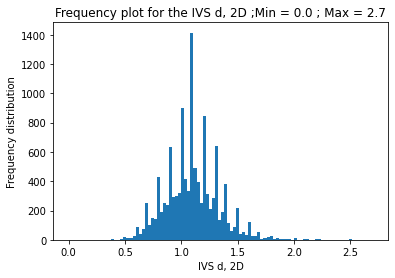

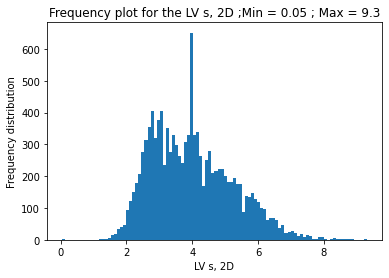

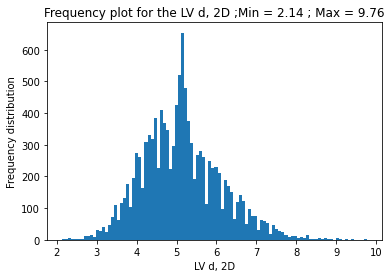

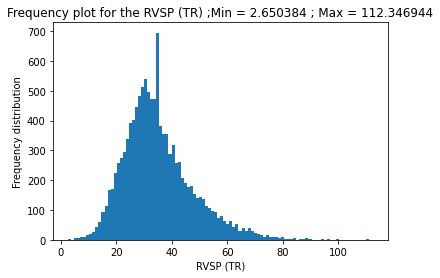

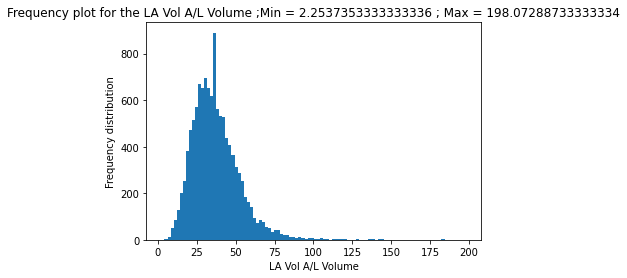

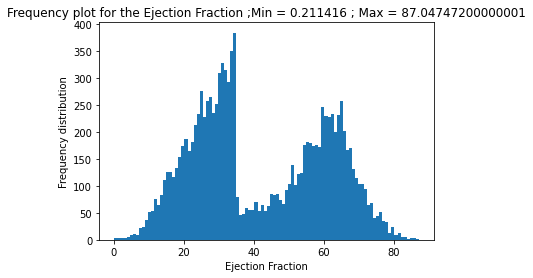

In [62]:
print("After MICE imputation")
plot_var(df_mice['IVS d, 2D'],"IVS d, 2D")
plot_var(df_mice['LV s, 2D'],"LV s, 2D")
plot_var(df_mice['LV d, 2D'],"LV d, 2D")
plot_var(df_mice["RVSP (TR)"],"RVSP (TR)")
plot_var(df_mice["LA Vol A/L Volume"],"LA Vol A/L Volume")
plot_var(df_mice["Ejection_Fraction"],"Ejection Fraction")

#EM PLOTS

After EM imputation


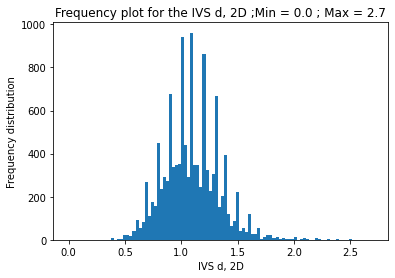

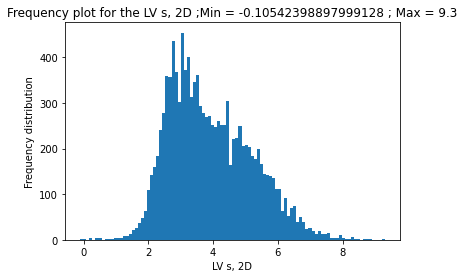

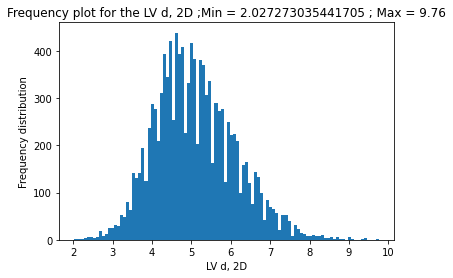

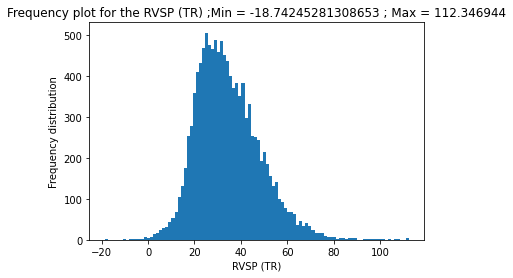

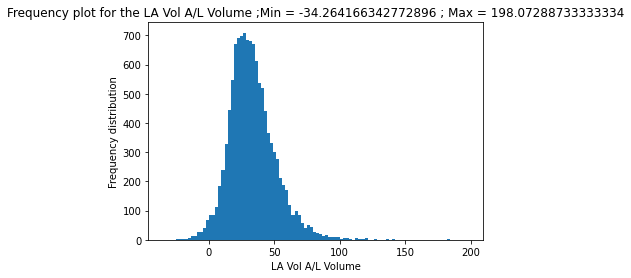

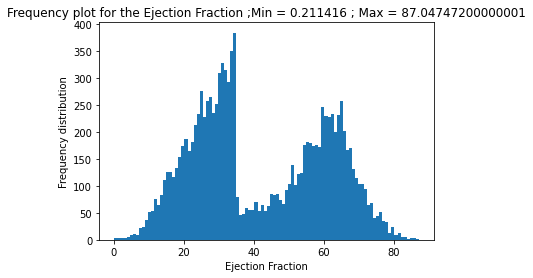

In [63]:
print("After EM imputation")
plot_var(df_em['IVS d, 2D'],"IVS d, 2D")
plot_var(df_em['LV s, 2D'],"LV s, 2D")
plot_var(df_em['LV d, 2D'],"LV d, 2D")
plot_var(df_em["RVSP (TR)"],"RVSP (TR)")
plot_var(df_em["LA Vol A/L Volume"],"LA Vol A/L Volume")
plot_var(df_em["Ejection_Fraction"],"Ejection Fraction")

#ZERO PLOTS

After Zero imputation


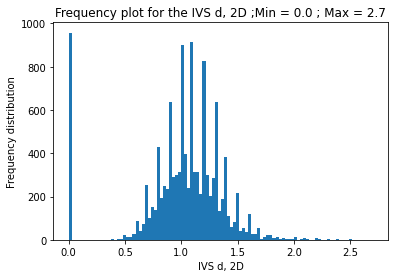

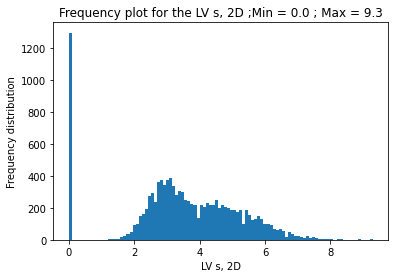

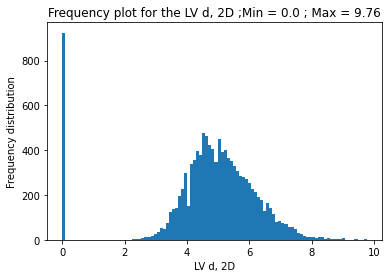

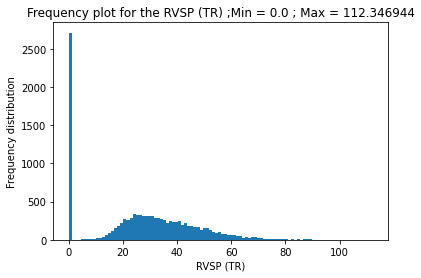

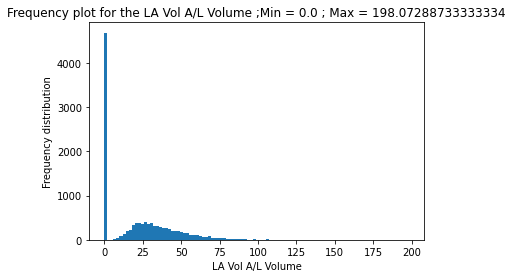

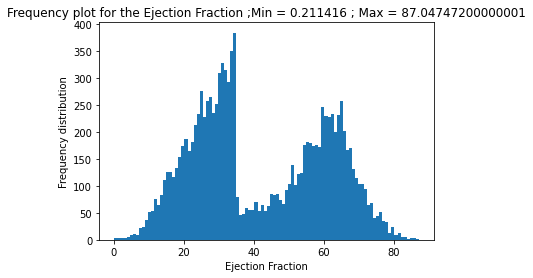

In [64]:
print("After Zero imputation")
plot_var(df_zero['IVS d, 2D'],"IVS d, 2D")
plot_var(df_zero['LV s, 2D'],"LV s, 2D")
plot_var(df_zero['LV d, 2D'],"LV d, 2D")
plot_var(df_zero["RVSP (TR)"],"RVSP (TR)")
plot_var(df_zero["LA Vol A/L Volume"],"LA Vol A/L Volume")
plot_var(df_zero["Ejection_Fraction"],"Ejection Fraction")

# Iterative SVD PLOTS

After Iterative SVD imputation


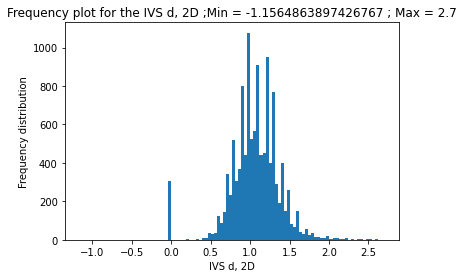

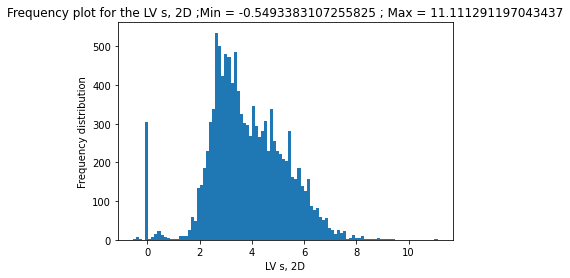

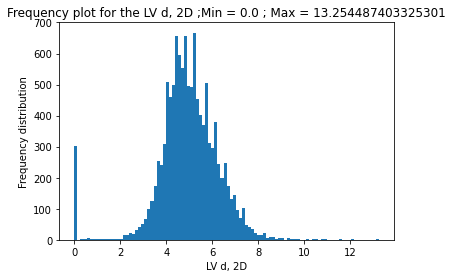

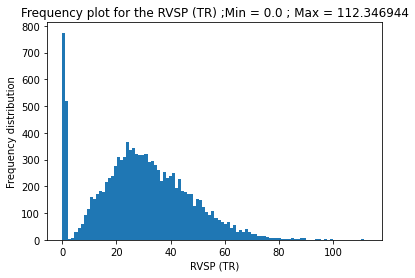

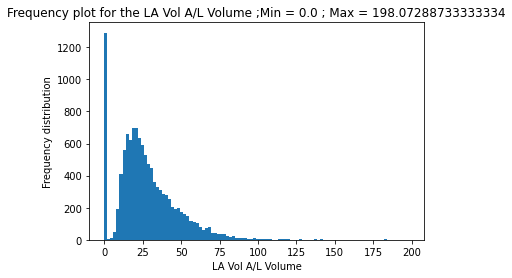

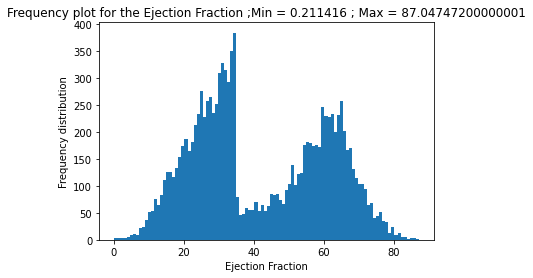

In [65]:
print("After Iterative SVD imputation")
plot_var(df_svd['IVS d, 2D'],"IVS d, 2D")
plot_var(df_svd['LV s, 2D'],"LV s, 2D")
plot_var(df_svd['LV d, 2D'],"LV d, 2D")
plot_var(df_svd["RVSP (TR)"],"RVSP (TR)")
plot_var(df_svd["LA Vol A/L Volume"],"LA Vol A/L Volume")
plot_var(df_svd["Ejection_Fraction"],"Ejection Fraction")

# Iterative Imputation

After Iterative Imputation imputation


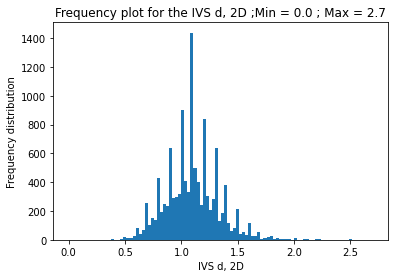

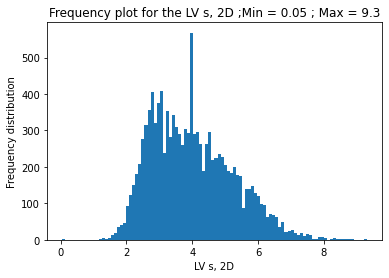

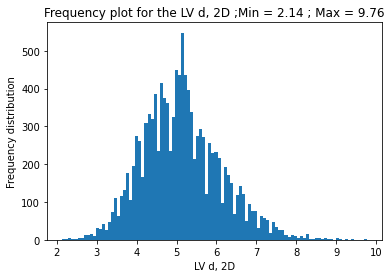

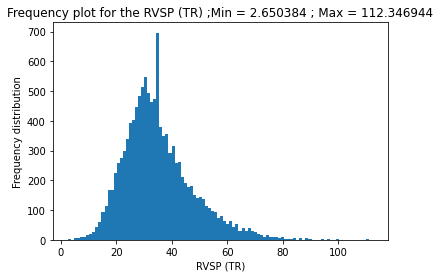

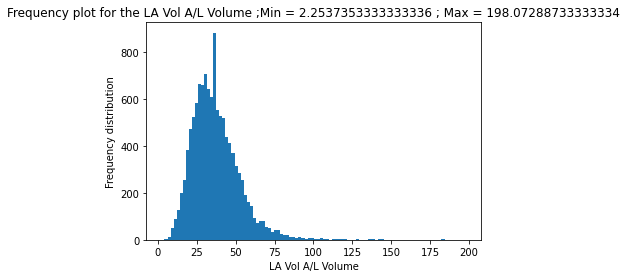

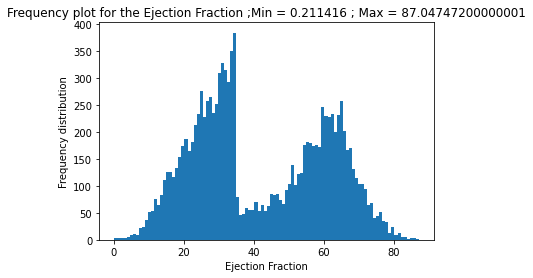

In [66]:
print("After Iterative Imputation imputation")
plot_var(df_iimp['IVS d, 2D'],"IVS d, 2D")
plot_var(df_iimp['LV s, 2D'],"LV s, 2D")
plot_var(df_iimp['LV d, 2D'],"LV d, 2D")
plot_var(df_iimp["RVSP (TR)"],"RVSP (TR)")
plot_var(df_iimp["LA Vol A/L Volume"],"LA Vol A/L Volume")
plot_var(df_iimp["Ejection_Fraction"],"Ejection Fraction")

#Remove all the negative values for each of the features since these are outliers

In [0]:
ind = df_mice[df_mice['Ejection_Fraction'] <= 0].index.tolist() + df_mice[df_mice['IVS d, 2D'] < 0].index.tolist() 
ind = ind + df_mice[df_mice['LV d, 2D'] < 0].index.tolist() + df_mice[df_mice['LV s, 2D'] < 0].index.tolist() 
ind += df_mice[df_mice['RVSP (TR)'] < 0].index.tolist() + df_mice[df_mice['LA Vol A/L Volume'] < 0].index.tolist()
df_mice_net = df_mice.drop(ind,axis=0)

In [0]:
ind = df_em[df_em['Ejection_Fraction'] <= 0].index.tolist() + df_em[df_em['IVS d, 2D'] < 0].index.tolist() 
ind = ind + df_em[df_em['LV d, 2D'] < 0].index.tolist() + df_em[df_em['LV s, 2D'] < 0].index.tolist() 
ind += df_em[df_em['RVSP (TR)'] < 0].index.tolist() + df_em[df_em['LA Vol A/L Volume'] < 0].index.tolist()
df_em_net = df_em.drop(ind,axis=0)

In [0]:
ind = df_svd[df_svd['Ejection_Fraction'] <= 0].index.tolist() + df_svd[df_svd['IVS d, 2D'] < 0].index.tolist() 
ind = ind + df_svd[df_svd['LV d, 2D'] < 0].index.tolist() + df_svd[df_svd['LV s, 2D'] < 0].index.tolist() 
ind += df_svd[df_svd['RVSP (TR)'] < 0].index.tolist() + df_svd[df_svd['LA Vol A/L Volume'] < 0].index.tolist()
df_svd_net = df_svd.drop(ind,axis=0)

In [0]:
ind = df_iimp[df_iimp['Ejection_Fraction'] <= 0].index.tolist() + df_iimp[df_iimp['IVS d, 2D'] < 0].index.tolist() 
ind = ind + df_iimp[df_iimp['LV d, 2D'] < 0].index.tolist() + df_iimp[df_iimp['LV s, 2D'] < 0].index.tolist() 
ind += df_iimp[df_iimp['RVSP (TR)'] < 0].index.tolist() + df_iimp[df_iimp['LA Vol A/L Volume'] < 0].index.tolist()
df_iimp_net = df_iimp.drop(ind,axis=0)

In [0]:
ind = df_backup_new[df_backup_new['Ejection_Fraction'] <= 0].index.tolist() + df_backup_new[df_backup_new['IVS d, 2D'] < 0].index.tolist() 
ind = ind + df_backup_new[df_backup_new['LV d, 2D'] < 0].index.tolist() + df_backup_new[df_backup_new['LV s, 2D'] < 0].index.tolist() 
ind += df_backup_new[df_backup_new['RVSP (TR)'] < 0].index.tolist() + df_backup_new[df_backup_new['LA Vol A/L Volume'] < 0].index.tolist()
df_backup_net = df_backup_new.drop(ind,axis=0)

In [72]:
df_mice_net.reset_index(drop=True,inplace=True)
df_mice_net.head(10)

,Pt. ID,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,7207336,1.090055,6.47,6.050,47.262400,53.207536,15.620880
1,2125776,0.900000,6.56,5.560,45.177600,48.690128,30.349615
2,1918995,0.800000,4.66,2.490,43.100844,31.032529,55.025044
3,1539299,0.864000,6.70,5.200,34.898423,40.665372,27.272727
4,204501,1.200000,4.10,2.500,30.457600,28.150037,65.277778
5,7077684,1.310000,4.81,3.110,31.419600,21.435557,71.002423
6,1320634,1.000000,4.60,2.900,58.552100,41.188500,72.197329
7,1009859,1.100000,5.60,5.100,58.552100,52.558208,26.058682
8,1549102,1.360000,4.70,3.575,45.250000,44.605335,34.589041
9,1499035,0.940000,5.49,5.170,36.832400,41.175328,23.800213


In [73]:
df_em_net.reset_index(drop=True,inplace=True)
df_em_net.head(10)

,Pt. ID,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,7207336,0.883121,6.47,6.050,47.262400,18.667855,15.620880
1,2125776,0.900000,6.56,5.560,45.177600,48.690128,30.349615
2,1918995,0.800000,4.66,2.490,43.100844,33.964245,55.025044
3,1539299,0.864000,6.70,5.200,22.274094,40.665372,27.272727
4,204501,1.200000,4.10,2.500,30.457600,7.100675,65.277778
5,7077684,1.310000,4.81,3.110,31.419600,21.435557,71.002423
6,1320634,1.000000,4.60,2.900,58.552100,33.286185,72.197329
7,1009859,1.100000,5.60,5.100,58.552100,39.149323,26.058682
8,1549102,1.360000,4.70,3.575,45.250000,44.605335,34.589041
9,1499035,0.940000,5.49,5.170,36.832400,21.545591,23.800213


In [74]:
df_svd_net.reset_index(drop=True,inplace=True)
df_svd_net.head(10)

,Pt. ID,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,7207336,1.11138,6.47,6.050,47.262400,24.113589,15.620880
1,2125776,0.90000,6.56,5.560,45.177600,48.690128,30.349615
2,1918995,0.80000,4.66,2.490,43.100844,21.548778,55.025044
3,1539299,0.86400,6.70,5.200,21.073566,40.665372,27.272727
4,204501,1.20000,4.10,2.500,30.457600,15.416914,65.277778
5,7077684,1.31000,4.81,3.110,31.419600,21.435557,71.002423
6,1320634,1.00000,4.60,2.900,58.552100,29.013270,72.197329
7,1009859,1.10000,5.60,5.100,58.552100,29.357562,26.058682
8,1549102,1.36000,4.70,3.575,45.250000,44.605335,34.589041
9,1499035,0.94000,5.49,5.170,36.832400,18.909243,23.800213


In [75]:
df_iimp_net.reset_index(drop=True,inplace=True)
df_iimp_net.head(10)

,Pt. ID,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,7207336,1.089504,6.47,6.050,47.262400,53.305764,15.620880
1,2125776,0.900000,6.56,5.560,45.177600,48.690128,30.349615
2,1918995,0.800000,4.66,2.490,43.100844,30.923426,55.025044
3,1539299,0.864000,6.70,5.200,35.037195,40.665372,27.272727
4,204501,1.200000,4.10,2.500,30.457600,28.031886,65.277778
5,7077684,1.310000,4.81,3.110,31.419600,21.435557,71.002423
6,1320634,1.000000,4.60,2.900,58.552100,41.028488,72.197329
7,1009859,1.100000,5.60,5.100,58.552100,52.566744,26.058682
8,1549102,1.360000,4.70,3.575,45.250000,44.605335,34.589041
9,1499035,0.940000,5.49,5.170,36.832400,41.317617,23.800213


In [76]:
df_backup_net.reset_index(drop=True,inplace=True)
df_backup_net.head(10)

,Pt. ID,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,621830,1.670000,4.980000,2.470000,43.836900,41.629523,74.272781
1,8211873,0.810000,4.340000,2.870000,23.250000,22.382333,59.485413
2,1138796,1.000000,2.570000,1.630000,32.075378,18.248036,66.487936
3,1166649,1.270000,3.940000,1.950000,36.918976,29.080671,72.222222
4,1553602,1.320000,4.360000,2.650000,31.999411,31.087242,63.945578
5,190563,1.260000,5.760000,4.020000,26.554844,37.141823,75.255434
6,2098292,1.130000,4.500000,2.940000,26.425600,27.987292,68.644068
7,875891,1.107006,4.692348,3.284922,32.187888,31.921662,8.695652
8,2098323,1.107006,4.692348,3.284922,32.187888,31.921662,19.893166
9,2043226,1.230000,5.350000,4.430000,36.518966,40.843483,30.215426


In [77]:
df_em_net.shape

(11555, 7)

In [78]:
df_mice_net.shape

(11764, 7)

In [79]:
df_zero.shape

(11764, 7)

In [80]:
df_svd_net.shape

(11750, 7)

In [81]:
df_iimp_net.shape

(11764, 7)

In [82]:
df_backup_net.shape

(54606, 7)

#After Outlier Detection Again; MICE plots

After MICE imputation and Outlier Detection


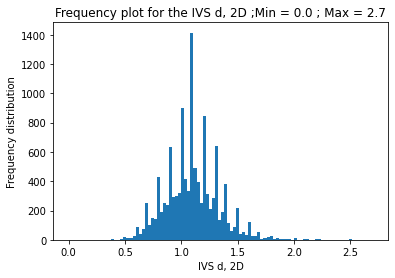

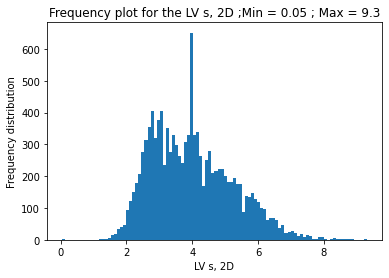

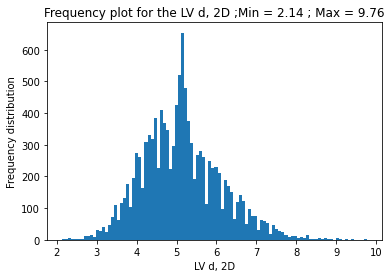

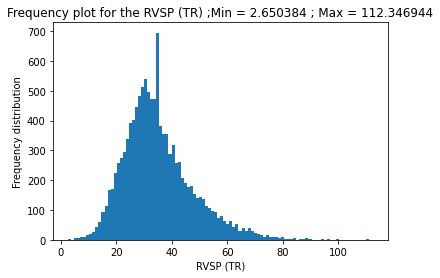

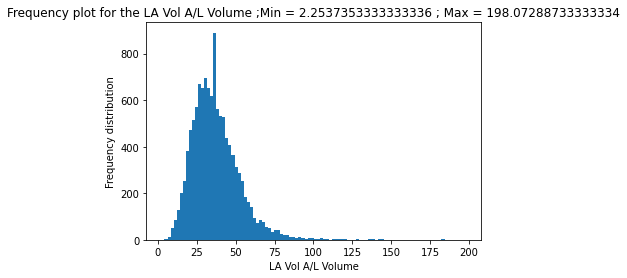

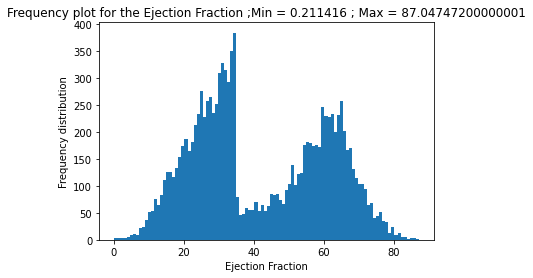

In [83]:
print("After MICE imputation and Outlier Detection")
plot_var(df_mice_net['IVS d, 2D'],"IVS d, 2D")
plot_var(df_mice_net['LV s, 2D'],"LV s, 2D")
plot_var(df_mice_net['LV d, 2D'],"LV d, 2D")
plot_var(df_mice_net["RVSP (TR)"],"RVSP (TR)")
plot_var(df_mice_net["LA Vol A/L Volume"],"LA Vol A/L Volume")
plot_var(df_mice_net["Ejection_Fraction"],"Ejection Fraction")

#After Outlier Detection ; EM Plots

After EM imputation


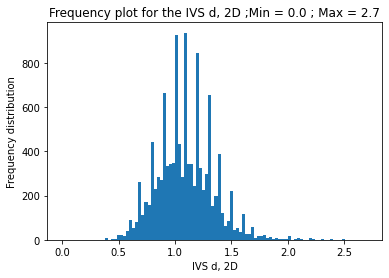

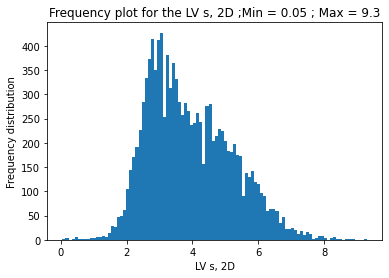

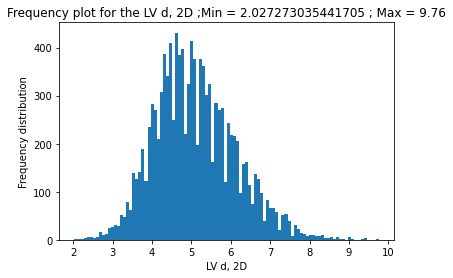

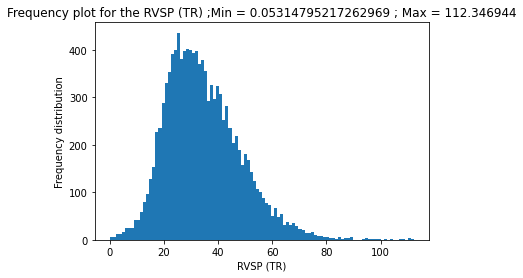

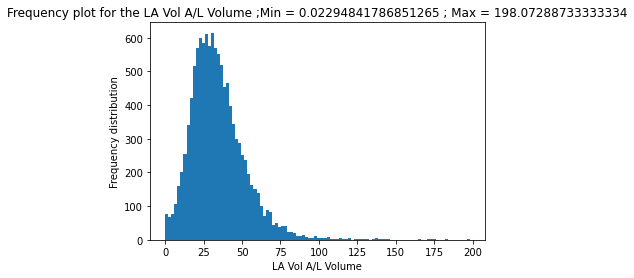

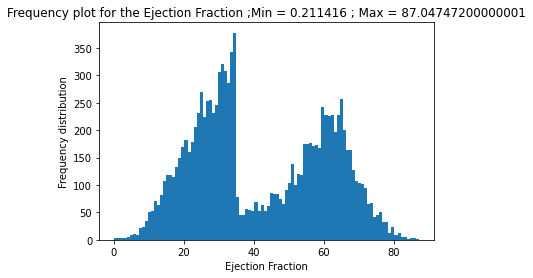

In [84]:
print("After EM imputation")
plot_var(df_em_net['IVS d, 2D'],"IVS d, 2D")
plot_var(df_em_net['LV s, 2D'],"LV s, 2D")
plot_var(df_em_net['LV d, 2D'],"LV d, 2D")
plot_var(df_em_net["RVSP (TR)"],"RVSP (TR)")
plot_var(df_em_net["LA Vol A/L Volume"],"LA Vol A/L Volume")
plot_var(df_em_net["Ejection_Fraction"],"Ejection Fraction")

# After Outlier Detection; Iterative SVD plots

After Iterative SVD imputation


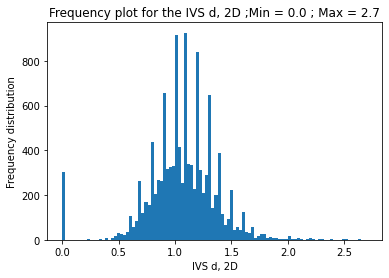

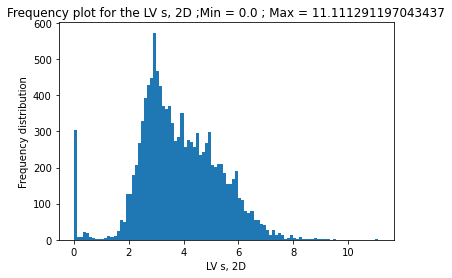

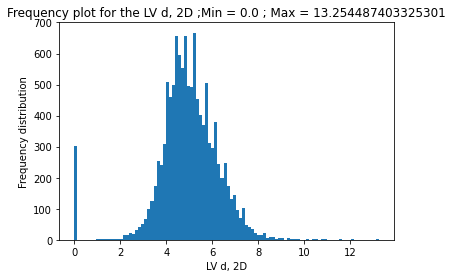

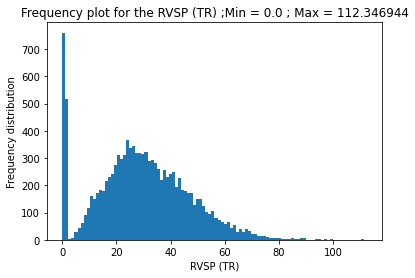

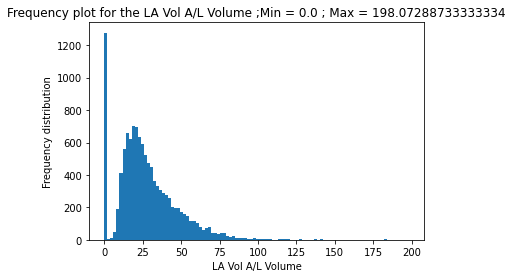

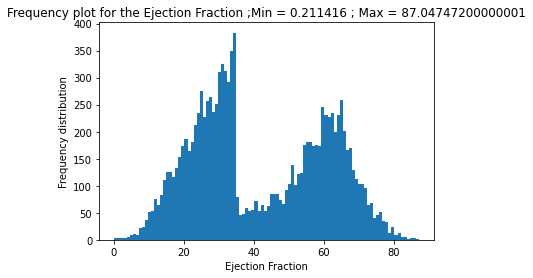

In [85]:
print("After Iterative SVD imputation")
plot_var(df_svd_net['IVS d, 2D'],"IVS d, 2D")
plot_var(df_svd_net['LV s, 2D'],"LV s, 2D")
plot_var(df_svd_net['LV d, 2D'],"LV d, 2D")
plot_var(df_svd_net["RVSP (TR)"],"RVSP (TR)")
plot_var(df_svd_net["LA Vol A/L Volume"],"LA Vol A/L Volume")
plot_var(df_svd_net["Ejection_Fraction"],"Ejection Fraction")

#Normalize the Output

In [0]:
def normalize(df):
  for col in df.columns[1:-1]:
    scaler = sklearn.preprocessing.MinMaxScaler()
    df[col] = scaler.fit_transform(np.array(df[col]).reshape((-1,1)))
  
  df[df.columns[-1]] = df[df.columns[-1]]/100.00
  return df

In [0]:
df_mice_net_norm = normalize(df_mice_net)
df_em_net_norm = normalize(df_em_net)
df_zero_net_norm = normalize(df_zero)
df_svd_net_norm = normalize(df_svd_net)
df_iimp_net_norm = normalize(df_iimp_net)
df_backup_net_norm = normalize(df_backup_net)

In [88]:
df_mice_net_norm.head(10)

,Pt. ID,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,7207336,0.403724,0.568241,0.648649,0.406686,0.260208,0.156209
1,2125776,0.333333,0.580052,0.595676,0.387680,0.237139,0.303496
2,1918995,0.296296,0.330709,0.263784,0.368749,0.146966,0.550250
3,1539299,0.320000,0.598425,0.556757,0.293975,0.196159,0.272727
4,204501,0.444444,0.257218,0.264865,0.253492,0.132246,0.652778
5,7077684,0.485185,0.350394,0.330811,0.262262,0.097957,0.710024
6,1320634,0.370370,0.322835,0.308108,0.509603,0.198830,0.721973
7,1009859,0.407407,0.454068,0.545946,0.509603,0.256893,0.260587
8,1549102,0.503704,0.335958,0.381081,0.388340,0.216279,0.345890
9,1499035,0.348148,0.439633,0.553514,0.311605,0.198763,0.238002


In [89]:
df_em_net_norm.head(10)

,Pt. ID,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,7207336,0.327082,0.574536,0.648649,0.420408,0.094142,0.156209
1,2125776,0.333333,0.586174,0.595676,0.401843,0.245732,0.303496
2,1918995,0.296296,0.340466,0.263784,0.383349,0.171377,0.550250
3,1539299,0.320000,0.604279,0.556757,0.197882,0.205213,0.272727
4,204501,0.444444,0.268046,0.264865,0.270758,0.035737,0.652778
5,7077684,0.485185,0.359864,0.330811,0.279325,0.108117,0.710024
6,1320634,0.370370,0.332706,0.308108,0.520946,0.167954,0.721973
7,1009859,0.407407,0.462027,0.545946,0.520946,0.197558,0.260587
8,1549102,0.503704,0.345638,0.381081,0.402488,0.225107,0.345890
9,1499035,0.348148,0.447802,0.553514,0.327527,0.108673,0.238002


In [90]:
df_zero_net_norm.head(10)

,Pt. ID,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,7207336,0.000000,0.662910,0.650538,0.420683,0.000000,0.156209
1,2125776,0.333333,0.672131,0.597849,0.402126,0.245819,0.303496
2,1918995,0.296296,0.477459,0.267742,0.383641,0.000000,0.550250
3,1539299,0.320000,0.686475,0.559140,0.000000,0.205305,0.272727
4,204501,0.444444,0.420082,0.268817,0.271103,0.000000,0.652778
5,7077684,0.485185,0.492828,0.334409,0.279666,0.108221,0.710024
6,1320634,0.370370,0.471311,0.311828,0.521172,0.000000,0.721973
7,1009859,0.407407,0.573770,0.548387,0.521172,0.000000,0.260587
8,1549102,0.503704,0.481557,0.384409,0.402770,0.225197,0.345890
9,1499035,0.348148,0.562500,0.555914,0.327845,0.000000,0.238002


In [91]:
df_svd_net_norm.head(10)

,Pt. ID,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,7207336,0.411622,0.488137,0.544491,0.420683,0.121741,0.156209
1,2125776,0.333333,0.494927,0.500392,0.402126,0.245819,0.303496
2,1918995,0.296296,0.351579,0.224096,0.383641,0.108792,0.550250
3,1539299,0.320000,0.505489,0.467992,0.187576,0.205305,0.272727
4,204501,0.444444,0.309329,0.224996,0.271103,0.077835,0.652778
5,7077684,0.485185,0.362896,0.279895,0.279666,0.108221,0.710024
6,1320634,0.370370,0.347052,0.260996,0.521172,0.146478,0.721973
7,1009859,0.407407,0.422498,0.458993,0.521172,0.148216,0.260587
8,1549102,0.503704,0.354597,0.321745,0.402770,0.225197,0.345890
9,1499035,0.348148,0.414199,0.465292,0.327845,0.095466,0.238002


In [92]:
df_iimp_net_norm.head(10)

,Pt. ID,"IVS d, 2D","LV d, 2D","LV s, 2D",RVSP (TR),LA Vol A/L Volume,Ejection_Fraction
0,7207336,0.403520,0.568241,0.648649,0.406686,0.260710,0.156209
1,2125776,0.333333,0.580052,0.595676,0.387680,0.237139,0.303496
2,1918995,0.296296,0.330709,0.263784,0.368749,0.146409,0.550250
3,1539299,0.320000,0.598425,0.556757,0.295240,0.196159,0.272727
4,204501,0.444444,0.257218,0.264865,0.253492,0.131643,0.652778
5,7077684,0.485185,0.350394,0.330811,0.262262,0.097957,0.710024
6,1320634,0.370370,0.322835,0.308108,0.509603,0.198013,0.721973
7,1009859,0.407407,0.454068,0.545946,0.509603,0.256936,0.260587
8,1549102,0.503704,0.335958,0.381081,0.388340,0.216279,0.345890
9,1499035,0.348148,0.439633,0.553514,0.311605,0.199490,0.238002


#Training the models

In [0]:
def graph_nn(losses, epochs,title):
    
    plt.figure(1)
    plt.plot(epochs, losses[0], label="Train")
    plt.plot(epochs, losses[1], label="Validation")
    plt.title(title)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [0]:
def binarize_output(output,limit = 0.35):
  processed_output = []
  for elem in output:
    if elem <= limit:
      processed_output.append(1)  #positive case for low EF
    else:
      processed_output.append(0)  #negative case for normal EF
  
  return processed_output

In [0]:
def basic_accuracy_metric(y_pred, y_truth):
  count = 0
  for i in range(len(y_pred)):
    if y_pred[i] == y_truth[i]:
      count = count + 1
  return count * 100.00/ len(y_pred)

In [0]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [0]:
def ANN(input_dim,num_outputs,num_neurons = None,activation = None,hidden_layers = None,loss = None,optimizer = None,output_activation = None,metric = None):
    model = None
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(num_neurons[0],input_dim = input_dim,activation = activation))
    for i in range(1,hidden_layers):
        model.add(keras.layers.Dense(num_neurons[i],activation = activation))
    
    model.add(keras.layers.Dense(num_outputs,activation = output_activation))
    print("Let's now compile the model")
    model.compile(loss=loss, optimizer=optimizer,metrics = metric)
    return model

In [0]:
def graphROC(all_trues,all_preds,num_splits=10):
  assert(len(all_trues)==len(all_preds)==num_splits)
  plt.figure(4)
  for foldno in range(num_splits):
    test,pred = all_trues[foldno],all_preds[foldno]
    fpr,tpr,_ = roc_curve(test,pred) #get the FPR and the TPR values
    AUCscore = roc_auc_score(test,pred,average = "micro") #Find AUC score
    plt.plot(fpr,tpr,label = "Fold "+str(foldno+1) + " AUC Score = " + str(round(AUCscore,2)))	#plot each fold
  
  FPR_av,TPR_av,_ = roc_curve(np.concatenate(all_trues),np.concatenate(all_preds)) #get the Average FPR and TPR
  AUCscoreav = roc_auc_score(np.concatenate(all_trues),np.concatenate(all_preds),average="micro") #get the micro average AUC score
  plt.plot(FPR_av,TPR_av,label = "Mean Curve with Average AUC score = " + str(round(AUCscoreav,2)))	#plot micro average curve also
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title("ROC curves for predicting EF")
  plt.legend()
  plt.show()

In [0]:
def graphPR(all_trues,all_preds,num_splits=10):
  assert(len(all_trues)==len(all_preds)==num_splits)
  plt.figure(4)
  for foldno in range(num_splits):
    test,pred = all_trues[foldno],all_preds[foldno]
    precision,recall,_ = precision_recall_curve(test,pred) #get the FPR and the TPR values
    AUPRCscore = average_precision_score(test,pred,average = "micro") #Find AUC score
    plt.plot(recall,precision,label = "Fold "+str(foldno+1) + " AUPRC Score = " + str(round(AUPRCscore,2)))	#plot each fold
  
  precision_av,recall_av,_ = precision_recall_curve(np.concatenate(all_trues),np.concatenate(all_preds)) #get the Average FPR and TPR
  AUPRCscoreav = average_precision_score(np.concatenate(all_trues),np.concatenate(all_preds),average="micro") #get the micro average AUC score
  plt.plot(recall_av,precision_av,label = "Mean Curve with Average AUPRC score = " + str(round(AUPRCscoreav,2)))	#plot micro average curve also
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title("PR curves for predicting EF")
  plt.legend()
  plt.show()

In [0]:
def KF_old(df,num_splits = 10,epochs = 5,batch_size = 20,main_title = None,model_params = None):
    kf = KFold(n_splits=num_splits, random_state = None)
    foldno = 1
    cross_val_scores = []
    raw_acc_scores = []
    features_picked = ["IVS d, 2D","LV d, 2D","LV s, 2D","RVSP (TR)","LA Vol A/L Volume"]
    output_feature = "Ejection_Fraction"

    all_trues = []
    all_preds = []

    title = "Confusion Matrix"
    print(main_title.upper())
    ids = df["Pt. ID"].unique() #get all the different patients
    #get the Kfold of the different unique IDs
    for train_index, test_index in kf.split(ids):
      print("FOLD NUMBER %d"%foldno)
      model = None
      start = time()
      print("TRAIN:", len(train_index), "TEST:", len(test_index))
      
      train_MRN, test_MRN = ids[train_index],ids[test_index]  #get the MRNs at the indices we split ; helps to get different MRNs in train and test
      df_train,df_test = df[df["Pt. ID"].isin(train_MRN)],df[df["Pt. ID"].isin(test_MRN)] #get the Dataframe associated
      
      X_train,X_test = df_train[features_picked].values,df_test[features_picked].values #get the X for each of them
      y_train, y_test = df_train[output_feature].values,df_test[output_feature].values  #get the Y for each of them

      y_train,y_test = y_train.reshape((-1,1)),y_test.reshape((-1,1)) #get the shape of Y's as a vector
      metric = model_params["metric"] #since we are regressing alone
      model = ANN(**model_params) #create the model fresh always
      
      #model = ANN(5,1,[100,50,10],"relu",3,"mean_squared_error",keras.optimizers.Adam(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999),"sigmoid",["mse"])
      
      if foldno == 1:
        model.summary()
        plot_model(model,to_file= main_title + '_model.png')

      #get the Count of the different outputs (less than 35% EF values)
      print(Counter(binarize_output(y_train.ravel())),"is the train counts of EF < 35%")
      print(Counter(binarize_output(y_test.ravel())),"is the test counts of EF < 35%")
      
      #fit the model
      history = model.fit(X_train,y_train,batch_size = batch_size,epochs = epochs,verbose = 0,validation_split = 0.1)
      
      #get the loss values and the predicted output
      scores = model.evaluate(X_test,y_test)
      y_output = model.predict(X_test)


      print("Test %s from the model: %.2f"%(metric[0],scores[0]))
      cross_val_scores.append(scores[0])
      
      #binarize the output based on the limit
      y_output_binarized = binarize_output(y_output)
      y_test_binarized = binarize_output(y_test)
      
      all_trues.append(y_test_binarized)
      all_preds.append(y_output_binarized)

      acc = basic_accuracy_metric(y_output_binarized, y_test_binarized)
      print("Raw accuracy calculated based on the limit EF < 35%: ",acc,"%")
      raw_acc_scores.append(acc)

      #plot and visualize the confusion matrix
      cnf_matrix = confusion_matrix(y_test_binarized,y_output_binarized)
      np.set_printoptions(precision=2)
      plot_confusion_matrix(cnf_matrix, classes=["Neg","Pos"])
      
      foldno += 1
      
      #get the loss history for train and validation to plot the same
      loss = history.history['loss']
      val_loss = history.history["val_loss"]

      graph_nn([loss,val_loss],range(1,epochs+1),f"{metric[0]} vs Epochs")  #plot the values
      print('\n')
      end = time()
      time_taken = (end - start)/60.00
      print("Time taken to run through %.2f minutes"%time_taken)
    
    
    print("The mean %s across %d folds is %.2f"%(metric[0],num_splits,np.mean(cross_val_scores))) #final cross val score
    print("The mean raw accuracy across %d folds is %.2f%%"%(num_splits,np.mean(raw_acc_scores))) #final raw accuracy score
    
    graphROC(all_trues,all_preds,10)
    graphPR(all_trues,all_preds,10)
    return None
    

In [0]:
def binary_recall_specificity(y_true, y_pred, recall_weight,spec_weight,mse_weight,limit = 0.35):

    #find TP, TN, FP, FN all using y_true, y_pred and then use the below stuff
    y_truebin = K.flatten(y_true) <= limit
    y_predbin = K.flatten(y_pred) <= limit
    

    #TP,TN = tf.metrics.true_positives(y_true,y_pred),tf.metrics.true_negatives(y_true,y_pred)
    #FP,FN = tf.metrics.false_positives(y_true,y_pred),tf.metrics.false_negatives(y_true,y_pred)
    cm = tf.confusion_matrix(y_truebin,y_predbin)
    TN,FP,FN,TP = tf.cast(cm[0][0],"float32"),tf.cast(cm[0][1],"float"),tf.cast(cm[1][0],"float"),tf.cast(cm[1][1],"float")

    #TP = K.cast(K.flatten(TP),"float32")
    #TN = K.cast(K.flatten(TN),"float32")
    #FP = K.cast(K.flatten(FP),"float32")
    #FN = K.cast(K.flatten(FN),"float32")
    
    #TN = np.logical_and(K.eval(y_true) == 0, K.eval(y_pred) == 0)
    #TP = np.logical_and(K.eval(y_true) == 1, K.eval(y_pred) == 1)

    #FP = np.logical_and(K.eval(y_true) == 0, K.eval(y_pred) == 1)
    #FN = np.logical_and(K.eval(y_true) == 1, K.eval(y_pred) == 0)

    # Converted as Keras Tensors
    #TN = K.sum(K.variable(TN))
    #FP = K.sum(K.variable(FP))
    
    specificity = TN/ (TN + FP + K.epsilon())
    recall = TP / (TP + FN + K.epsilon())
    #rel_acc = (TP + TN)/(FN + FP + K.epsilon())

    return (1 - (recall_weight*recall + spec_weight*specificity) + mse_weight * tf.losses.mean_squared_error(K.flatten(y_true),K.flatten(y_pred)))
    #return (1 - (acc_weight * rel_acc) + (mse_weight * tf.losses.mean_squared_error(K.flatten(y_true),K.flatten(y_pred))))

def custom_loss(recall_weight,spec_weight,mse_weight):

    def recall_spec_loss(y_true, y_pred):
        return binary_recall_specificity(y_true, y_pred, recall_weight,spec_weight,mse_weight)

    # Returns the (y_true, y_pred) loss function
    return recall_spec_loss

In [0]:
def KF(df,num_splits = 10,epochs = 5,batch_size = 20,main_title = None,model_params = None):
    kf = KFold(n_splits=num_splits, random_state = None)
    foldno = 1
    cross_val_scores = []
    raw_acc_scores = []
    recall_scores = []
    precision_scores = []
    f1_scores = []
    features_picked = ["IVS d, 2D","LV d, 2D","LV s, 2D","RVSP (TR)","LA Vol A/L Volume"]
    output_feature = "Ejection_Fraction"

    all_trues = []
    all_preds = []

    title = "Confusion Matrix"
    print(main_title.upper())
    ids = df["Pt. ID"].unique() #get all the different patients
    #get the Kfold of the different unique IDs
    for train_index, test_index in kf.split(ids):
      print("FOLD NUMBER %d"%foldno)
      model = None
      start = time()
      print("TRAIN:", len(train_index), "TEST:", len(test_index))
      
      train_MRN, test_MRN = ids[train_index],ids[test_index]  #get the MRNs at the indices we split ; helps to get different MRNs in train and test
      df_train,df_test = df[df["Pt. ID"].isin(train_MRN)],df[df["Pt. ID"].isin(test_MRN)] #get the Dataframe associated
      
      #balancing stuff goes in here
      arr = (df_test['Ejection_Fraction'] <= 0.35).values
      pos = np.where(arr == True)[0]
      neg = np.where(arr == False)[0]
      test_size = min(len(pos),len(neg))
      pos_df,neg_df = df_test.iloc[pos],df_test.iloc[neg]
      pos_df_net = pos_df.sample(n=test_size,replace=False)
      neg_df_net = neg_df.sample(n=test_size,replace=False)
      assert(pos_df_net.shape == neg_df_net.shape)
      net_df_test = pd.concat([pos_df_net,neg_df_net],axis=0).sample(frac=1).reset_index(drop=True)

      X_train,X_test = df_train[features_picked].values,net_df_test[features_picked].values #get the X for each of them
      y_train, y_test = df_train[output_feature].values,net_df_test[output_feature].values  #get the Y for each of them

      #y_train,y_test = y_train.reshape((-1,1)),y_test.reshape((-1,1)) #get the shape of Y's as a vector
      metric = model_params["metric"] #since we are regressing alone
      model = ANN(**model_params) #create the model fresh always


      if foldno == 1:
        model.summary()
        plot_model(model,to_file= main_title + '_model.png')

      #get the Count of the different outputs (less than 35% EF values)
      print(Counter(binarize_output(y_train.ravel())),"is the train counts of EF < 35%")
      print(Counter(binarize_output(y_test.ravel())),"is the test counts of EF < 35%")
      
      
      #fit the model
      history = model.fit(X_train,y_train,batch_size = batch_size,epochs = epochs,verbose = 0,validation_split = 0.1)
      
      #get the loss values and the predicted output
      scores = model.evaluate(X_test,y_test)
      y_output = model.predict(X_test)


      print("Test %s from the model: %.2f"%(metric[0],scores[0]))
      cross_val_scores.append(scores[0])
      
      #binarize the output based on the limit
      y_output_binarized = binarize_output(y_output)
      y_test_binarized = binarize_output(y_test)
      
      all_trues.append(y_test_binarized)
      all_preds.append(y_output_binarized)

      acc = basic_accuracy_metric(y_output_binarized, y_test_binarized)
      print("Raw accuracy calculated based on the limit EF < 35%: ",acc,"%")
      raw_acc_scores.append(acc)

      recall = recall_score(y_test_binarized,y_output_binarized) * 100.00
      precision = precision_score(y_test_binarized,y_output_binarized) * 100.00
      f1 = f1_score(y_test_binarized,y_output_binarized) * 100.00

      print("Recall score for this fold based on the limit EF < 35%: ",recall,"%")
      print("Precision score for this fold based on the limit EF < 35%: ",precision,"%")
      print("F1 score for this fold based on the limit EF < 35%: ",f1,"%")

      recall_scores.append(recall)
      precision_scores.append(precision)
      f1_scores.append(f1)

      #plot and visualize the confusion matrix
      cnf_matrix = confusion_matrix(y_test_binarized,y_output_binarized)
      np.set_printoptions(precision=2)
      plot_confusion_matrix(cnf_matrix, classes=["Neg","Pos"])
      
      foldno += 1
      
      #get the loss history for train and validation to plot the same
      loss = history.history['loss']
      val_loss = history.history["val_loss"]

      graph_nn([loss,val_loss],range(1,epochs+1),f"{metric[0]} vs Epochs")  #plot the values
      print('\n')
      end = time()
      time_taken = (end - start)/60.00
      print("Time taken to run through %.2f minutes"%time_taken)
    
    
    print("The mean %s across %d folds is %.2f"%(metric[0],num_splits,np.mean(cross_val_scores))) #final cross val score
    print("The mean raw accuracy across %d folds is %.2f%%"%(num_splits,np.mean(raw_acc_scores))) #final raw accuracy score
    print("The mean recall score across %d folds is %.2f%%"%(num_splits,np.mean(recall_scores))) #final recall score
    print("The mean precision score across %d folds is %.2f%%"%(num_splits,np.mean(precision_scores))) #final precision score
    print("The mean f1 score across %d folds is %.2f%%"%(num_splits,np.mean(f1_scores))) #final f1 scores

    graphROC(all_trues,all_preds,num_splits)
    graphPR(all_trues,all_preds,num_splits)
    return None

#MICE MODEL

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
MICE MISSING VALUE IMPUTATION
FOLD NUMBER 1
TRAIN: 7939 TEST: 883
Let's now compile the model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 6,171
Trainable params: 6,171
Non-trainable params: 0
_________________________________________________________________
Counter({0: 5299, 1: 4789}) is the train counts of EF < 35%
Counter({1: 583

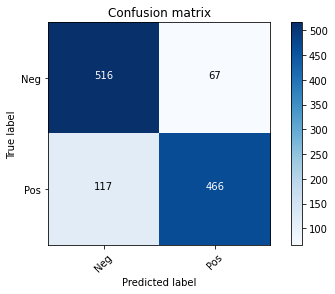

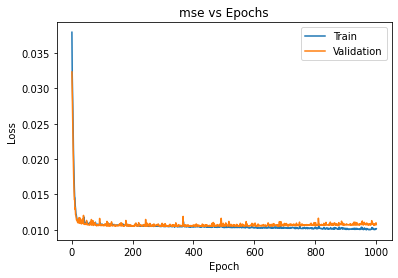



Time taken to run through 0.53 minutes
FOLD NUMBER 2
TRAIN: 7939 TEST: 883
Let's now compile the model
Counter({0: 5286, 1: 5056}) is the train counts of EF < 35%
Counter({1: 596, 0: 596}) is the test counts of EF < 35%
1192/1192 [==============================] - 0s 14us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  85.48657718120805 %
Recall score for this fold based on the limit EF < 35%:  87.91946308724832 %
Precision score for this fold based on the limit EF < 35%:  83.84 %
F1 score for this fold based on the limit EF < 35%:  85.83128583128583 %


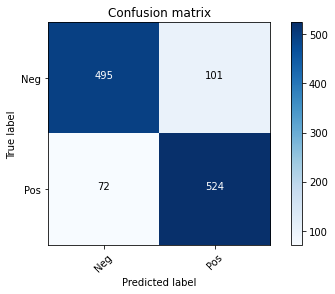

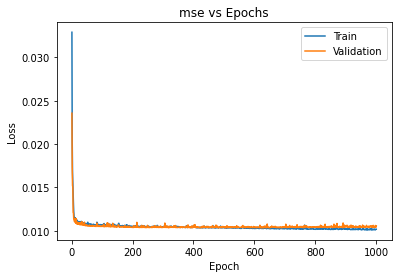



Time taken to run through 0.52 minutes
FOLD NUMBER 3
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({0: 5312, 1: 5050}) is the train counts of EF < 35%
Counter({0: 570, 1: 570}) is the test counts of EF < 35%
1140/1140 [==============================] - 0s 18us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  84.12280701754386 %
Recall score for this fold based on the limit EF < 35%:  78.7719298245614 %
Precision score for this fold based on the limit EF < 35%:  88.21218074656188 %
F1 score for this fold based on the limit EF < 35%:  83.22520852641334 %


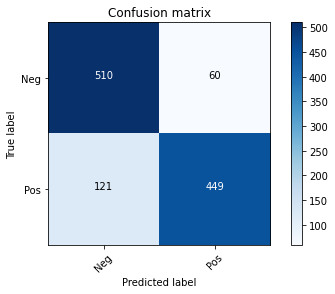

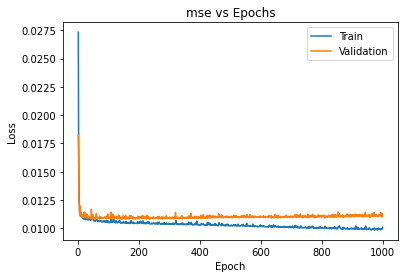



Time taken to run through 0.53 minutes
FOLD NUMBER 4
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({0: 5317, 1: 5219}) is the train counts of EF < 35%
Counter({1: 565, 0: 565}) is the test counts of EF < 35%
1130/1130 [==============================] - 0s 15us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  83.1858407079646 %
Recall score for this fold based on the limit EF < 35%:  76.46017699115045 %
Precision score for this fold based on the limit EF < 35%:  88.34355828220859 %
F1 score for this fold based on the limit EF < 35%:  81.97343453510436 %


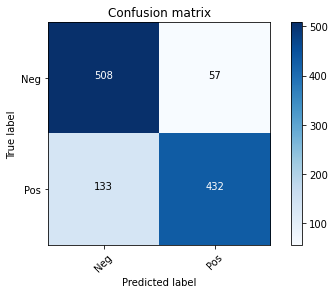

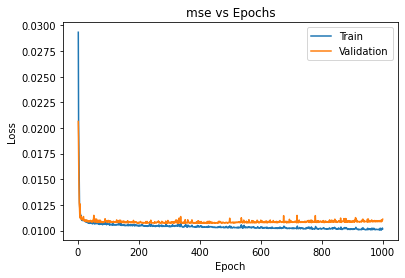



Time taken to run through 0.55 minutes
FOLD NUMBER 5
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({0: 5320, 1: 5310}) is the train counts of EF < 35%
Counter({1: 562, 0: 562}) is the test counts of EF < 35%
1124/1124 [==============================] - 0s 15us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  82.82918149466192 %
Recall score for this fold based on the limit EF < 35%:  71.70818505338077 %
Precision score for this fold based on the limit EF < 35%:  92.21967963386729 %
F1 score for this fold based on the limit EF < 35%:  80.6806806806807 %


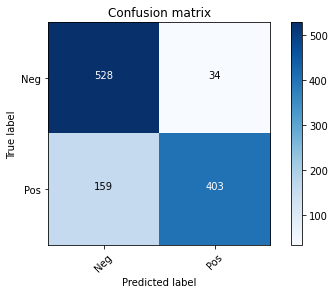

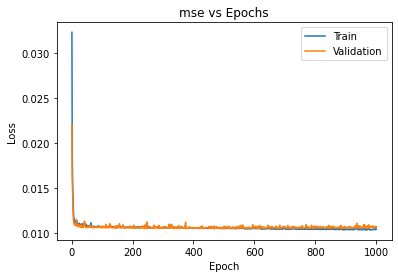



Time taken to run through 0.54 minutes
FOLD NUMBER 6
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({1: 5398, 0: 5277}) is the train counts of EF < 35%
Counter({0: 484, 1: 484}) is the test counts of EF < 35%
968/968 [==============================] - 0s 17us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  83.98760330578513 %
Recall score for this fold based on the limit EF < 35%:  76.03305785123968 %
Precision score for this fold based on the limit EF < 35%:  90.41769041769042 %
F1 score for this fold based on the limit EF < 35%:  82.60381593714928 %


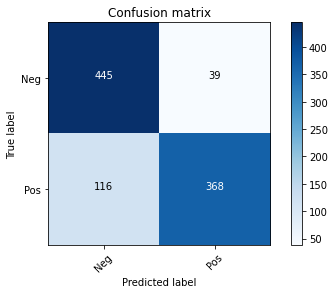

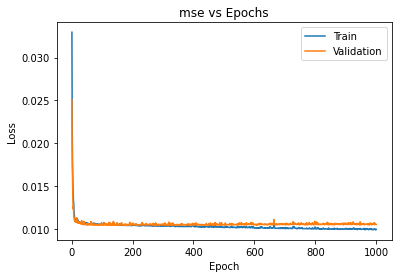



Time taken to run through 0.56 minutes
FOLD NUMBER 7
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({1: 5460, 0: 5271}) is the train counts of EF < 35%
Counter({1: 422, 0: 422}) is the test counts of EF < 35%
844/844 [==============================] - 0s 18us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  84.83412322274881 %
Recall score for this fold based on the limit EF < 35%:  77.96208530805687 %
Precision score for this fold based on the limit EF < 35%:  90.38461538461539 %
F1 score for this fold based on the limit EF < 35%:  83.7150127226463 %


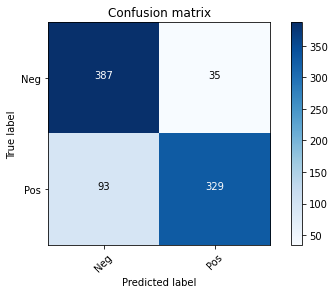

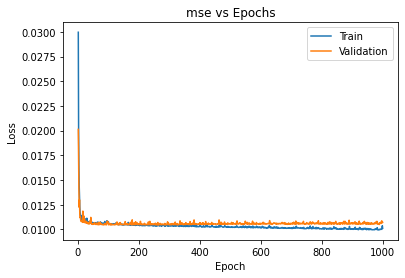



Time taken to run through 0.57 minutes
FOLD NUMBER 8
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({1: 5503, 0: 5305}) is the train counts of EF < 35%
Counter({1: 379, 0: 379}) is the test counts of EF < 35%
758/758 [==============================] - 0s 20us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  83.24538258575198 %
Recall score for this fold based on the limit EF < 35%:  72.0316622691293 %
Precision score for this fold based on the limit EF < 35%:  92.85714285714286 %
F1 score for this fold based on the limit EF < 35%:  81.12927191679049 %


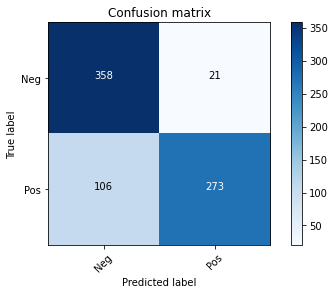

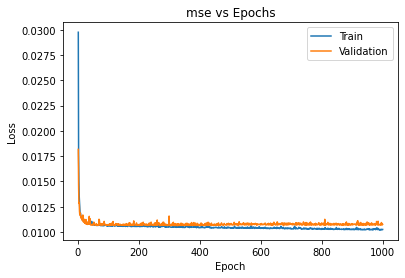



Time taken to run through 0.57 minutes
FOLD NUMBER 9
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({1: 5559, 0: 5280}) is the train counts of EF < 35%
Counter({0: 323, 1: 323}) is the test counts of EF < 35%
646/646 [==============================] - 0s 21us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  82.50773993808049 %
Recall score for this fold based on the limit EF < 35%:  73.06501547987617 %
Precision score for this fold based on the limit EF < 35%:  90.07633587786259 %
F1 score for this fold based on the limit EF < 35%:  80.68376068376068 %


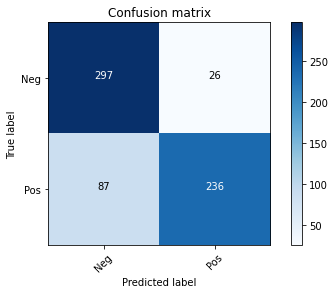

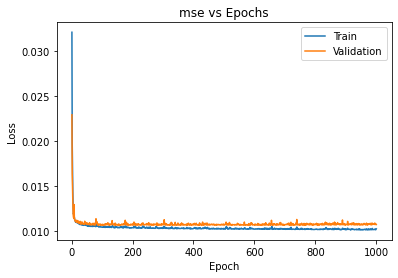



Time taken to run through 0.58 minutes
FOLD NUMBER 10
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({1: 5594, 0: 5271}) is the train counts of EF < 35%
Counter({0: 288, 1: 288}) is the test counts of EF < 35%
576/576 [==============================] - 0s 22us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  85.76388888888889 %
Recall score for this fold based on the limit EF < 35%:  79.51388888888889 %
Precision score for this fold based on the limit EF < 35%:  90.87301587301587 %
F1 score for this fold based on the limit EF < 35%:  84.81481481481481 %


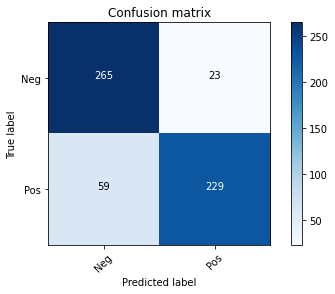

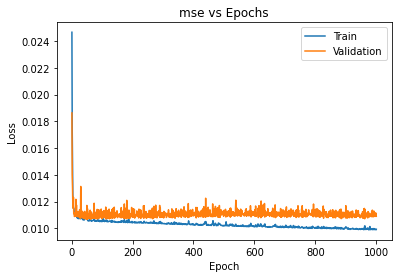



Time taken to run through 0.58 minutes
The mean mse across 10 folds is 0.01
The mean raw accuracy across 10 folds is 84.02%
The mean recall score across 10 folds is 77.34%
The mean precision score across 10 folds is 89.47%
The mean f1 score across 10 folds is 82.82%


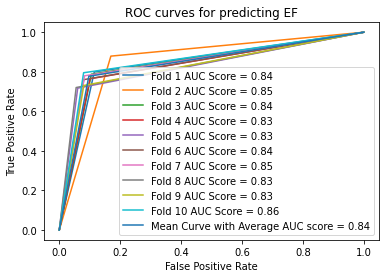

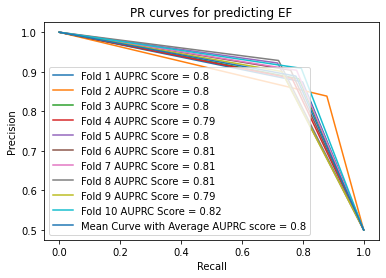

In [103]:
#baseline model parameters
#This is on the MICE normalized data
import warnings
warnings.filterwarnings("ignore")

model_params = {"input_dim":5,"num_outputs":1,"num_neurons": [100,50,10],"activation": "relu","hidden_layers": 3,
              "loss": "mean_squared_error","optimizer": keras.optimizers.Adam(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999),
                "output_activation": "sigmoid","metric": ["mse"]}

KF(df_mice_net_norm,num_splits=10,epochs=1000,batch_size=1000,
   main_title="MICE missing value imputation",
   model_params=model_params)

#EM Model

EM MISSING VALUE IMPUTATION
FOLD NUMBER 1
TRAIN: 7828 TEST: 870
Let's now compile the model
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 100)               600       
_________________________________________________________________
dense_42 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_43 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 11        
Total params: 6,171
Trainable params: 6,171
Non-trainable params: 0
_________________________________________________________________
Counter({0: 5219, 1: 4697}) is the train counts of EF < 35%
Counter({0: 571, 1: 571}) is the test counts of EF < 35%
1142/1142 [=============================

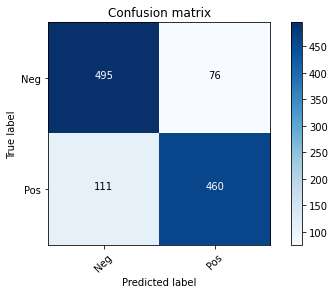

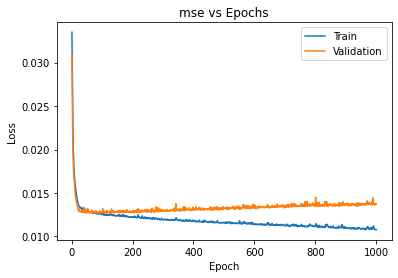



Time taken to run through 0.54 minutes
FOLD NUMBER 2
TRAIN: 7828 TEST: 870
Let's now compile the model
Counter({0: 5202, 1: 4961}) is the train counts of EF < 35%
Counter({0: 588, 1: 588}) is the test counts of EF < 35%
1176/1176 [==============================] - 0s 20us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  83.33333333333333 %
Recall score for this fold based on the limit EF < 35%:  77.89115646258503 %
Precision score for this fold based on the limit EF < 35%:  87.40458015267176 %
F1 score for this fold based on the limit EF < 35%:  82.37410071942446 %


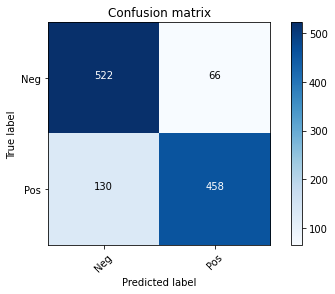

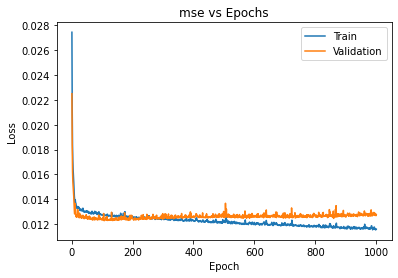



Time taken to run through 0.59 minutes
FOLD NUMBER 3
TRAIN: 7828 TEST: 870
Let's now compile the model
Counter({0: 5230, 1: 4961}) is the train counts of EF < 35%
Counter({0: 560, 1: 560}) is the test counts of EF < 35%
1120/1120 [==============================] - 0s 20us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  83.39285714285714 %
Recall score for this fold based on the limit EF < 35%:  76.60714285714286 %
Precision score for this fold based on the limit EF < 35%:  88.63636363636364 %
F1 score for this fold based on the limit EF < 35%:  82.18390804597702 %


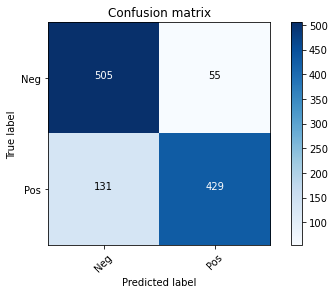

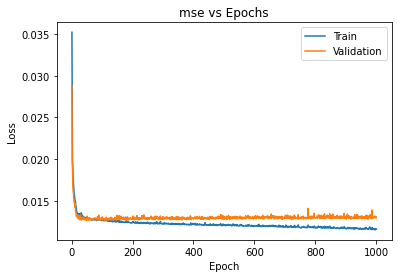



Time taken to run through 0.61 minutes
FOLD NUMBER 4
TRAIN: 7828 TEST: 870
Let's now compile the model
Counter({0: 5239, 1: 5105}) is the train counts of EF < 35%
Counter({0: 551, 1: 551}) is the test counts of EF < 35%
1102/1102 [==============================] - 0s 23us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  81.48820326678766 %
Recall score for this fold based on the limit EF < 35%:  74.41016333938293 %
Precision score for this fold based on the limit EF < 35%:  86.68076109936575 %
F1 score for this fold based on the limit EF < 35%:  80.078125 %


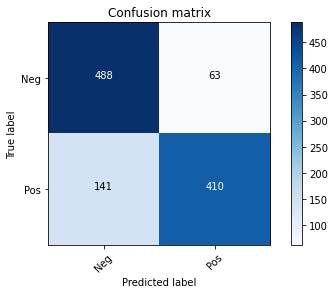

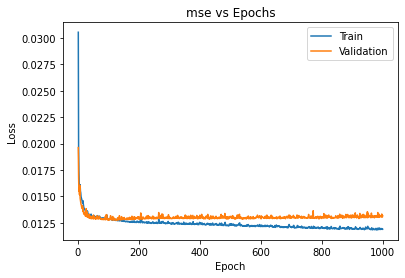



Time taken to run through 0.61 minutes
FOLD NUMBER 5
TRAIN: 7828 TEST: 870
Let's now compile the model
Counter({0: 5233, 1: 5207}) is the train counts of EF < 35%
Counter({0: 557, 1: 557}) is the test counts of EF < 35%
1114/1114 [==============================] - 0s 25us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  82.76481149012567 %
Recall score for this fold based on the limit EF < 35%:  76.12208258527828 %
Precision score for this fold based on the limit EF < 35%:  87.78467908902692 %
F1 score for this fold based on the limit EF < 35%:  81.53846153846153 %


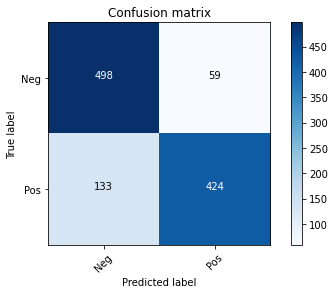

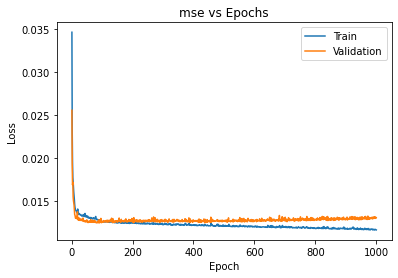



Time taken to run through 0.62 minutes
FOLD NUMBER 6
TRAIN: 7828 TEST: 870
Let's now compile the model
Counter({1: 5287, 0: 5194}) is the train counts of EF < 35%
Counter({1: 478, 0: 478}) is the test counts of EF < 35%
956/956 [==============================] - 0s 26us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  84.72803347280335 %
Recall score for this fold based on the limit EF < 35%:  76.98744769874477 %
Precision score for this fold based on the limit EF < 35%:  91.0891089108911 %
F1 score for this fold based on the limit EF < 35%:  83.44671201814059 %


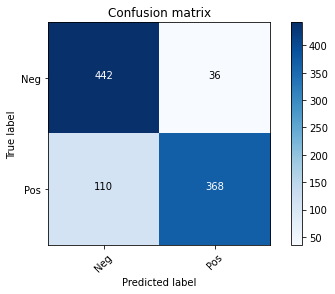

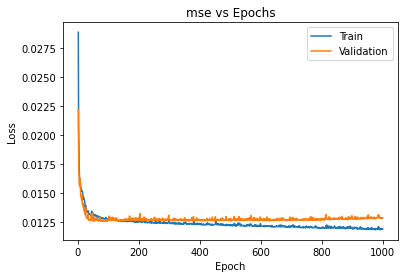



Time taken to run through 0.62 minutes
FOLD NUMBER 7
TRAIN: 7828 TEST: 870
Let's now compile the model
Counter({1: 5350, 0: 5188}) is the train counts of EF < 35%
Counter({0: 415, 1: 415}) is the test counts of EF < 35%
830/830 [==============================] - 0s 25us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  81.32530120481928 %
Recall score for this fold based on the limit EF < 35%:  71.08433734939759 %
Precision score for this fold based on the limit EF < 35%:  89.39393939393939 %
F1 score for this fold based on the limit EF < 35%:  79.19463087248322 %


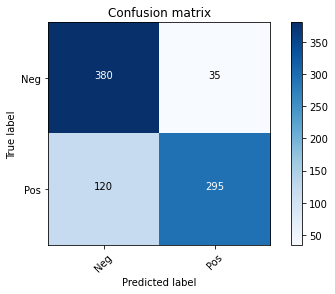

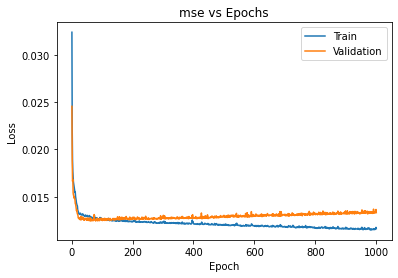



Time taken to run through 0.64 minutes
FOLD NUMBER 8
TRAIN: 7828 TEST: 870
Let's now compile the model
Counter({1: 5393, 0: 5218}) is the train counts of EF < 35%
Counter({0: 372, 1: 372}) is the test counts of EF < 35%
744/744 [==============================] - 0s 27us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  80.64516129032258 %
Recall score for this fold based on the limit EF < 35%:  68.01075268817203 %
Precision score for this fold based on the limit EF < 35%:  91.00719424460432 %
F1 score for this fold based on the limit EF < 35%:  77.84615384615385 %


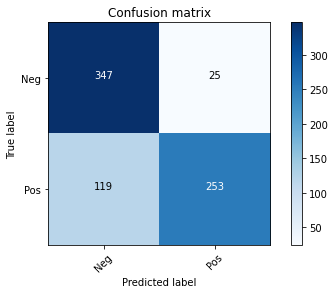

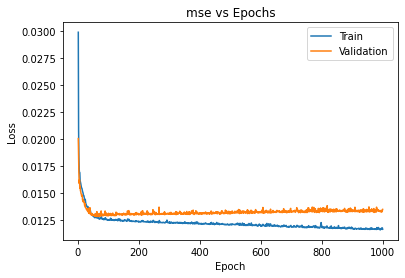



Time taken to run through 0.65 minutes
FOLD NUMBER 9
TRAIN: 7829 TEST: 869
Let's now compile the model
Counter({1: 5444, 0: 5198}) is the train counts of EF < 35%
Counter({1: 321, 0: 321}) is the test counts of EF < 35%
642/642 [==============================] - 0s 29us/step
Test mse from the model: 0.02
Raw accuracy calculated based on the limit EF < 35%:  82.86604361370716 %
Recall score for this fold based on the limit EF < 35%:  71.02803738317756 %
Precision score for this fold based on the limit EF < 35%:  93.06122448979592 %
F1 score for this fold based on the limit EF < 35%:  80.56537102473497 %


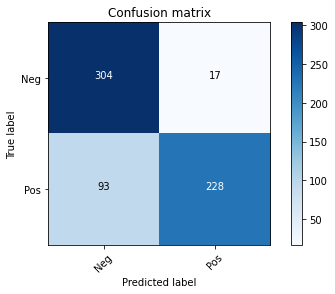

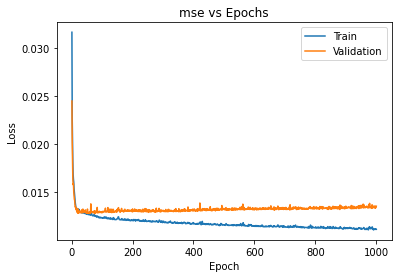



Time taken to run through 0.65 minutes
FOLD NUMBER 10
TRAIN: 7829 TEST: 869
Let's now compile the model
Counter({1: 5480, 0: 5189}) is the train counts of EF < 35%
Counter({0: 285, 1: 285}) is the test counts of EF < 35%
570/570 [==============================] - 0s 31us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  86.3157894736842 %
Recall score for this fold based on the limit EF < 35%:  77.19298245614034 %
Precision score for this fold based on the limit EF < 35%:  94.4206008583691 %
F1 score for this fold based on the limit EF < 35%:  84.94208494208493 %


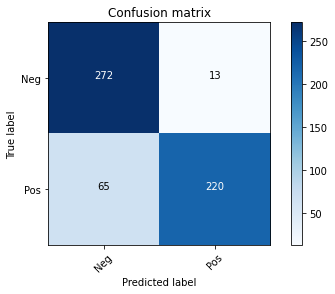

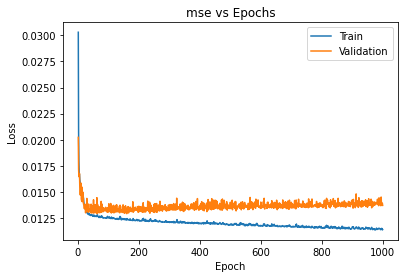



Time taken to run through 0.67 minutes
The mean mse across 10 folds is 0.01
The mean raw accuracy across 10 folds is 83.05%
The mean recall score across 10 folds is 74.99%
The mean precision score across 10 folds is 89.53%
The mean f1 score across 10 folds is 81.53%


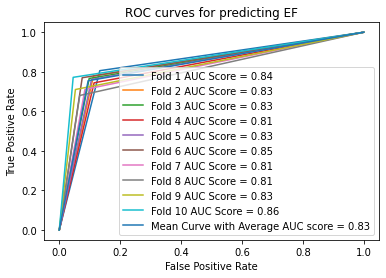

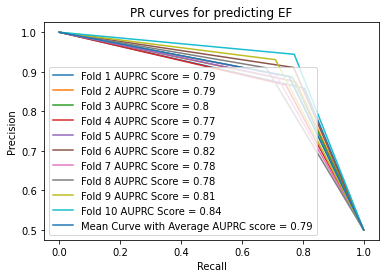

In [104]:
import warnings
warnings.filterwarnings("ignore")

model_params = {"input_dim":5,"num_outputs":1,"num_neurons": [100,50,10],"activation": "relu","hidden_layers": 3,
              "loss": "mean_squared_error","optimizer": keras.optimizers.Adam(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999),
                "output_activation": "sigmoid","metric": ["mse"]}

KF(df_em_net_norm,num_splits=10,epochs=1000,batch_size=1000,
   main_title="EM missing value imputation",
   model_params=model_params)

#Zero-Filling Model

ZERO-FILLED MISSING VALUE IMPUTATION
FOLD NUMBER 1
TRAIN: 7939 TEST: 883
Let's now compile the model
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 100)               600       
_________________________________________________________________
dense_82 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_83 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 11        
Total params: 6,171
Trainable params: 6,171
Non-trainable params: 0
_________________________________________________________________
Counter({0: 5299, 1: 4789}) is the train counts of EF < 35%
Counter({1: 583, 0: 583}) is the test counts of EF < 35%
1166/1166 [====================

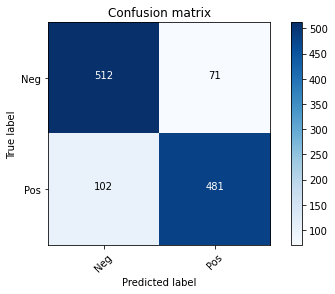

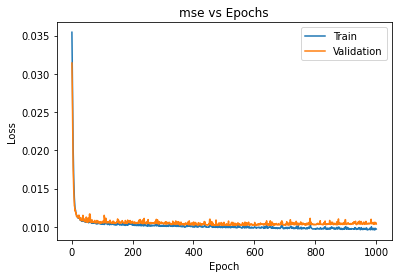



Time taken to run through 0.67 minutes
FOLD NUMBER 2
TRAIN: 7939 TEST: 883
Let's now compile the model
Counter({0: 5286, 1: 5056}) is the train counts of EF < 35%
Counter({0: 596, 1: 596}) is the test counts of EF < 35%
1192/1192 [==============================] - 0s 32us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  85.40268456375838 %
Recall score for this fold based on the limit EF < 35%:  87.41610738255034 %
Precision score for this fold based on the limit EF < 35%:  84.03225806451613 %
F1 score for this fold based on the limit EF < 35%:  85.6907894736842 %


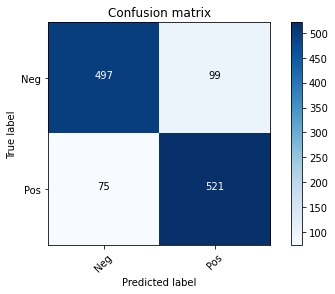

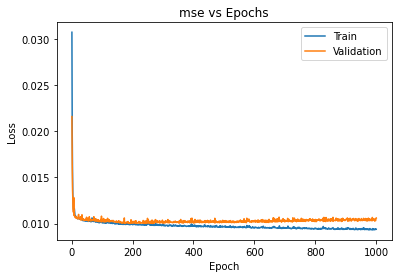



Time taken to run through 0.69 minutes
FOLD NUMBER 3
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({0: 5312, 1: 5050}) is the train counts of EF < 35%
Counter({1: 570, 0: 570}) is the test counts of EF < 35%
1140/1140 [==============================] - 0s 28us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  85.0 %
Recall score for this fold based on the limit EF < 35%:  82.45614035087719 %
Precision score for this fold based on the limit EF < 35%:  86.87615526802219 %
F1 score for this fold based on the limit EF < 35%:  84.60846084608461 %


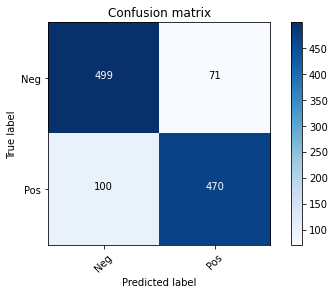

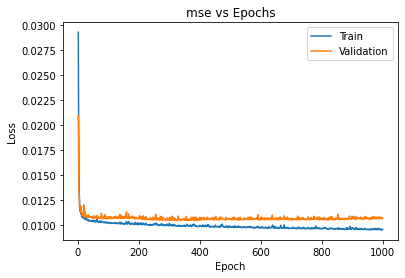



Time taken to run through 0.68 minutes
FOLD NUMBER 4
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({0: 5317, 1: 5219}) is the train counts of EF < 35%
Counter({0: 565, 1: 565}) is the test counts of EF < 35%
1130/1130 [==============================] - 0s 32us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  83.6283185840708 %
Recall score for this fold based on the limit EF < 35%:  78.23008849557522 %
Precision score for this fold based on the limit EF < 35%:  87.6984126984127 %
F1 score for this fold based on the limit EF < 35%:  82.69410664172123 %


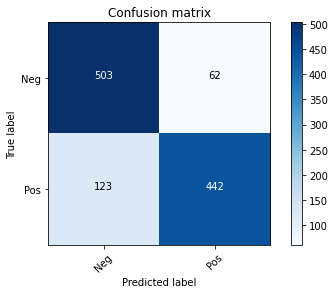

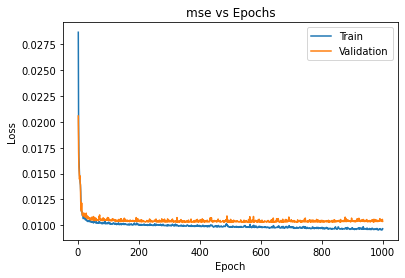



Time taken to run through 0.70 minutes
FOLD NUMBER 5
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({0: 5320, 1: 5310}) is the train counts of EF < 35%
Counter({0: 562, 1: 562}) is the test counts of EF < 35%
1124/1124 [==============================] - 0s 31us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  85.05338078291815 %
Recall score for this fold based on the limit EF < 35%:  78.82562277580071 %
Precision score for this fold based on the limit EF < 35%:  90.04065040650406 %
F1 score for this fold based on the limit EF < 35%:  84.0607210626186 %


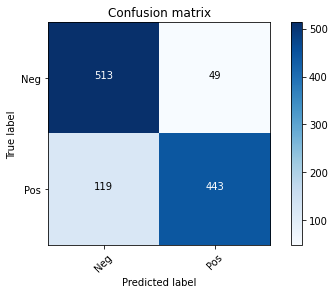

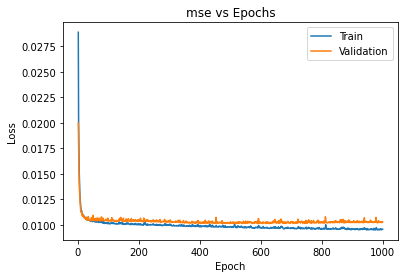



Time taken to run through 0.71 minutes
FOLD NUMBER 6
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({1: 5398, 0: 5277}) is the train counts of EF < 35%
Counter({0: 484, 1: 484}) is the test counts of EF < 35%
968/968 [==============================] - 0s 31us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  82.02479338842976 %
Recall score for this fold based on the limit EF < 35%:  70.45454545454545 %
Precision score for this fold based on the limit EF < 35%:  91.66666666666666 %
F1 score for this fold based on the limit EF < 35%:  79.67289719626169 %


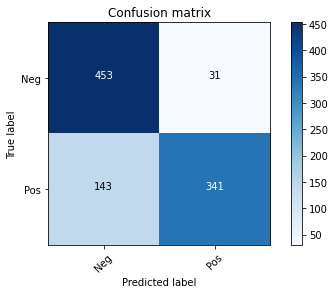

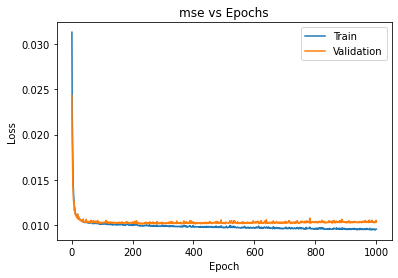



Time taken to run through 0.72 minutes
FOLD NUMBER 7
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({1: 5460, 0: 5271}) is the train counts of EF < 35%
Counter({0: 422, 1: 422}) is the test counts of EF < 35%
844/844 [==============================] - 0s 31us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  83.64928909952607 %
Recall score for this fold based on the limit EF < 35%:  76.77725118483413 %
Precision score for this fold based on the limit EF < 35%:  89.01098901098901 %
F1 score for this fold based on the limit EF < 35%:  82.44274809160305 %


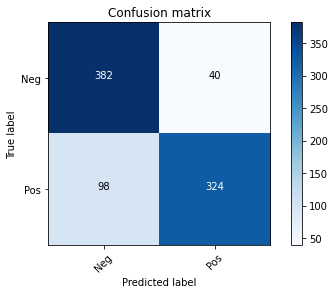

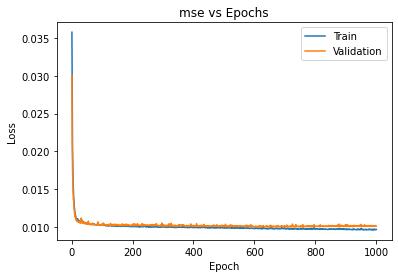



Time taken to run through 0.72 minutes
FOLD NUMBER 8
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({1: 5503, 0: 5305}) is the train counts of EF < 35%
Counter({1: 379, 0: 379}) is the test counts of EF < 35%
758/758 [==============================] - 0s 34us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  87.73087071240106 %
Recall score for this fold based on the limit EF < 35%:  83.37730870712402 %
Precision score for this fold based on the limit EF < 35%:  91.32947976878613 %
F1 score for this fold based on the limit EF < 35%:  87.17241379310344 %


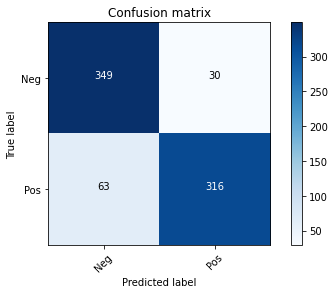

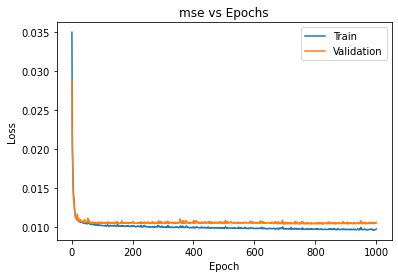



Time taken to run through 0.74 minutes
FOLD NUMBER 9
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({1: 5559, 0: 5280}) is the train counts of EF < 35%
Counter({1: 323, 0: 323}) is the test counts of EF < 35%
646/646 [==============================] - 0s 34us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  84.6749226006192 %
Recall score for this fold based on the limit EF < 35%:  77.08978328173374 %
Precision score for this fold based on the limit EF < 35%:  90.87591240875912 %
F1 score for this fold based on the limit EF < 35%:  83.41708542713567 %


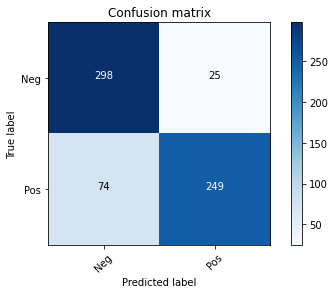

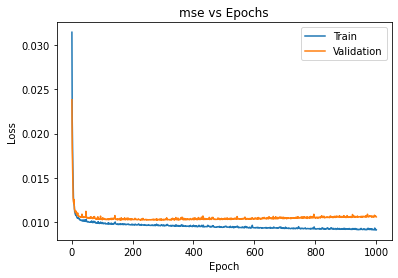



Time taken to run through 0.75 minutes
FOLD NUMBER 10
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({1: 5594, 0: 5271}) is the train counts of EF < 35%
Counter({0: 288, 1: 288}) is the test counts of EF < 35%
576/576 [==============================] - 0s 35us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  85.06944444444444 %
Recall score for this fold based on the limit EF < 35%:  76.04166666666666 %
Precision score for this fold based on the limit EF < 35%:  92.79661016949152 %
F1 score for this fold based on the limit EF < 35%:  83.58778625954199 %


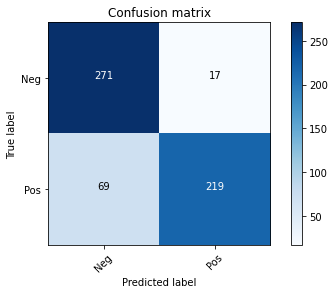

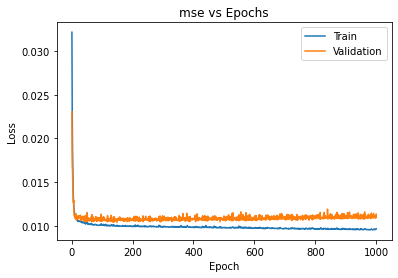



Time taken to run through 0.74 minutes
The mean mse across 10 folds is 0.01
The mean raw accuracy across 10 folds is 84.74%
The mean recall score across 10 folds is 79.32%
The mean precision score across 10 folds is 89.15%
The mean f1 score across 10 folds is 83.81%


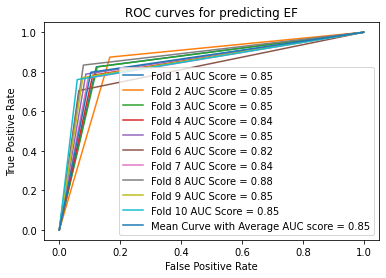

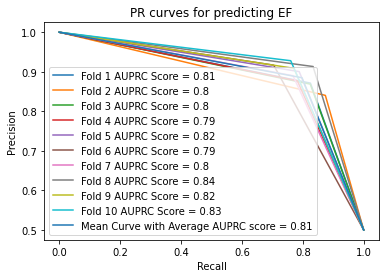

In [105]:
import warnings
warnings.filterwarnings("ignore")

model_params = {"input_dim":5,"num_outputs":1,"num_neurons": [100,50,10],"activation": "relu","hidden_layers": 3,
              "loss": "mean_squared_error","optimizer": keras.optimizers.Adam(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999),
                "output_activation": "sigmoid","metric": ["mse"]}

KF(df_zero_net_norm,num_splits=10,epochs=1000,batch_size=1000,
   main_title="Zero-filled missing value imputation",
   model_params=model_params)

# Iterative SVD Model

SVD MISSING VALUE IMPUTATION
FOLD NUMBER 1
TRAIN: 7931 TEST: 882
Let's now compile the model
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 100)               600       
_________________________________________________________________
dense_122 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_123 (Dense)            (None, 10)                510       
_________________________________________________________________
dense_124 (Dense)            (None, 1)                 11        
Total params: 6,171
Trainable params: 6,171
Non-trainable params: 0
_________________________________________________________________
Counter({0: 5294, 1: 4784}) is the train counts of EF < 35%
Counter({1: 583, 0: 583}) is the test counts of EF < 35%
1166/1166 [============================

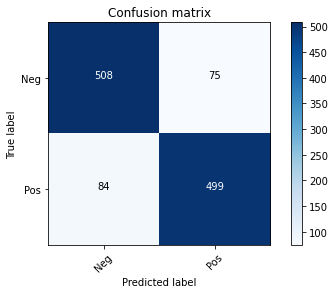

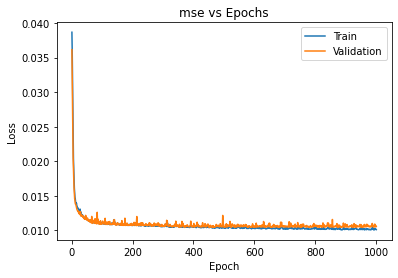



Time taken to run through 0.73 minutes
FOLD NUMBER 2
TRAIN: 7931 TEST: 882
Let's now compile the model
Counter({0: 5280, 1: 5051}) is the train counts of EF < 35%
Counter({1: 597, 0: 597}) is the test counts of EF < 35%
1194/1194 [==============================] - 0s 33us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  85.25963149078727 %
Recall score for this fold based on the limit EF < 35%:  86.09715242881072 %
Precision score for this fold based on the limit EF < 35%:  84.67874794069192 %
F1 score for this fold based on the limit EF < 35%:  85.38205980066445 %


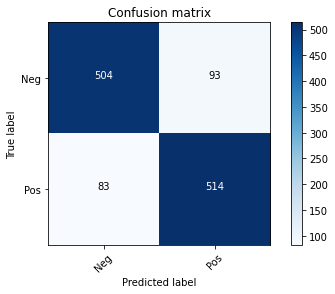

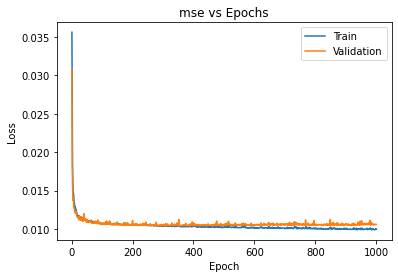



Time taken to run through 0.76 minutes
FOLD NUMBER 3
TRAIN: 7931 TEST: 882
Let's now compile the model
Counter({0: 5309, 1: 5037}) is the train counts of EF < 35%
Counter({0: 568, 1: 568}) is the test counts of EF < 35%
1136/1136 [==============================] - 0s 36us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  85.91549295774648 %
Recall score for this fold based on the limit EF < 35%:  86.26760563380282 %
Precision score for this fold based on the limit EF < 35%:  85.66433566433567 %
F1 score for this fold based on the limit EF < 35%:  85.96491228070175 %


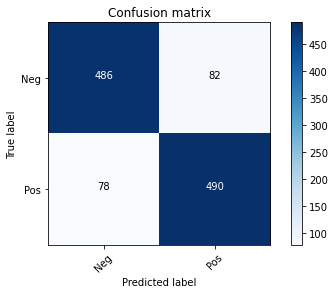

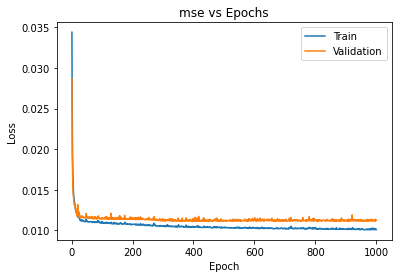



Time taken to run through 0.77 minutes
FOLD NUMBER 4
TRAIN: 7932 TEST: 881
Let's now compile the model
Counter({0: 5312, 1: 5213}) is the train counts of EF < 35%
Counter({1: 565, 0: 565}) is the test counts of EF < 35%
1130/1130 [==============================] - 0s 37us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  83.98230088495575 %
Recall score for this fold based on the limit EF < 35%:  83.00884955752213 %
Precision score for this fold based on the limit EF < 35%:  84.65703971119135 %
F1 score for this fold based on the limit EF < 35%:  83.8248436103664 %


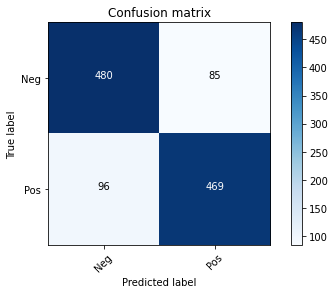

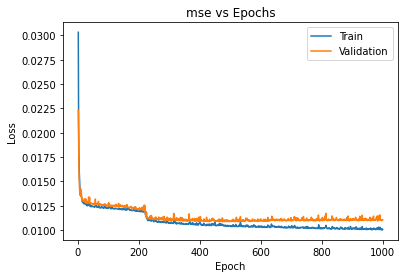



Time taken to run through 0.78 minutes
FOLD NUMBER 5
TRAIN: 7932 TEST: 881
Let's now compile the model
Counter({0: 5314, 1: 5305}) is the train counts of EF < 35%
Counter({1: 563, 0: 563}) is the test counts of EF < 35%
1126/1126 [==============================] - 0s 41us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  85.16873889875666 %
Recall score for this fold based on the limit EF < 35%:  81.34991119005328 %
Precision score for this fold based on the limit EF < 35%:  88.07692307692308 %
F1 score for this fold based on the limit EF < 35%:  84.57987072945522 %


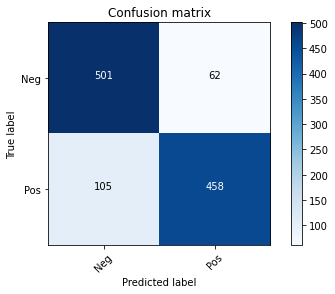

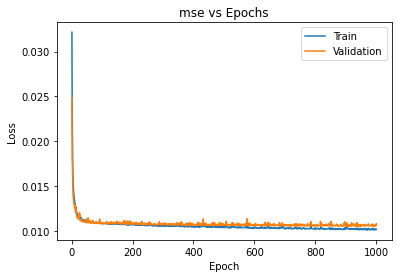



Time taken to run through 0.80 minutes
FOLD NUMBER 6
TRAIN: 7932 TEST: 881
Let's now compile the model
Counter({1: 5387, 0: 5274}) is the train counts of EF < 35%
Counter({1: 486, 0: 486}) is the test counts of EF < 35%
972/972 [==============================] - 0s 38us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  84.5679012345679 %
Recall score for this fold based on the limit EF < 35%:  78.39506172839506 %
Precision score for this fold based on the limit EF < 35%:  89.43661971830986 %
F1 score for this fold based on the limit EF < 35%:  83.55263157894737 %


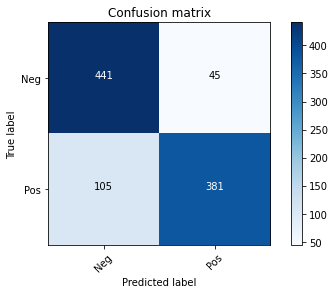

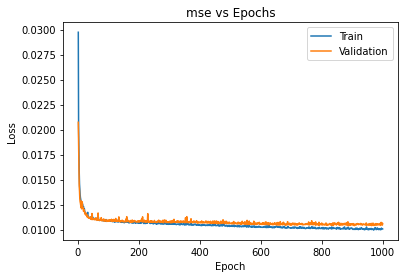



Time taken to run through 0.80 minutes
FOLD NUMBER 7
TRAIN: 7932 TEST: 881
Let's now compile the model
Counter({1: 5450, 0: 5266}) is the train counts of EF < 35%
Counter({0: 423, 1: 423}) is the test counts of EF < 35%
846/846 [==============================] - 0s 40us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  82.38770685579196 %
Recall score for this fold based on the limit EF < 35%:  73.28605200945626 %
Precision score for this fold based on the limit EF < 35%:  89.59537572254335 %
F1 score for this fold based on the limit EF < 35%:  80.62418725617685 %


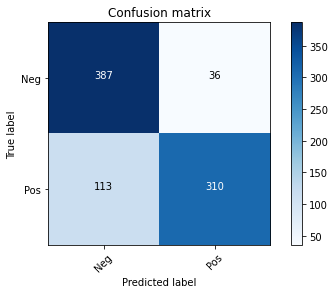

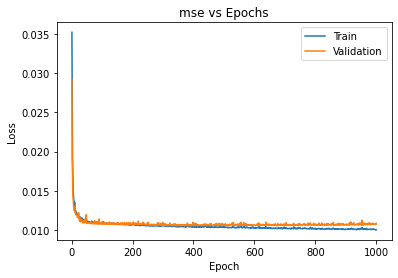



Time taken to run through 0.80 minutes
FOLD NUMBER 8
TRAIN: 7932 TEST: 881
Let's now compile the model
Counter({1: 5494, 0: 5301}) is the train counts of EF < 35%
Counter({1: 379, 0: 379}) is the test counts of EF < 35%
758/758 [==============================] - 0s 40us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  86.6754617414248 %
Recall score for this fold based on the limit EF < 35%:  81.26649076517151 %
Precision score for this fold based on the limit EF < 35%:  91.12426035502959 %
F1 score for this fold based on the limit EF < 35%:  85.91352859135286 %


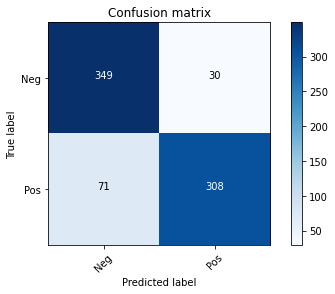

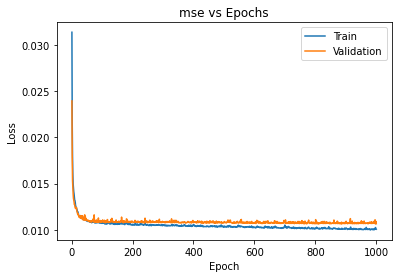



Time taken to run through 0.81 minutes
FOLD NUMBER 9
TRAIN: 7932 TEST: 881
Let's now compile the model
Counter({1: 5552, 0: 5275}) is the train counts of EF < 35%
Counter({0: 321, 1: 321}) is the test counts of EF < 35%
642/642 [==============================] - 0s 45us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  85.202492211838 %
Recall score for this fold based on the limit EF < 35%:  79.12772585669782 %
Precision score for this fold based on the limit EF < 35%:  90.0709219858156 %
F1 score for this fold based on the limit EF < 35%:  84.24543946932006 %


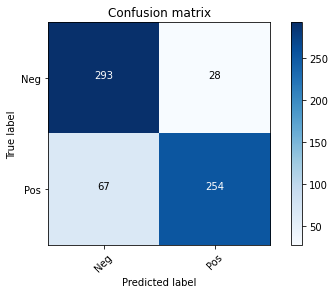

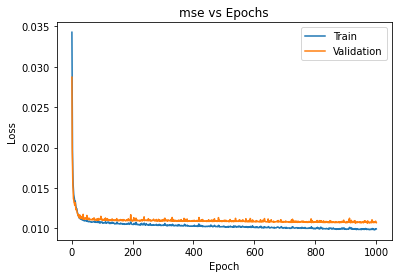



Time taken to run through 0.81 minutes
FOLD NUMBER 10
TRAIN: 7932 TEST: 881
Let's now compile the model
Counter({1: 5584, 0: 5268}) is the train counts of EF < 35%
Counter({0: 289, 1: 289}) is the test counts of EF < 35%
578/578 [==============================] - 0s 47us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  83.91003460207612 %
Recall score for this fold based on the limit EF < 35%:  73.35640138408304 %
Precision score for this fold based on the limit EF < 35%:  92.98245614035088 %
F1 score for this fold based on the limit EF < 35%:  82.01160541586074 %


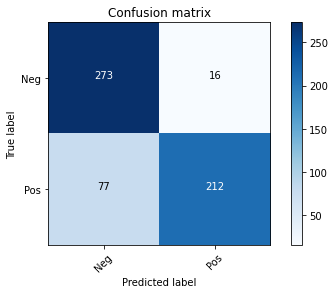

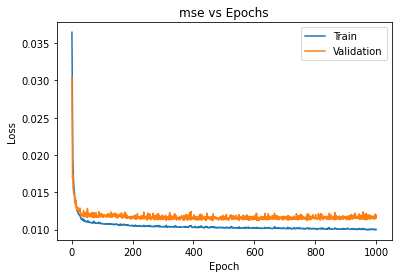



Time taken to run through 0.84 minutes
The mean mse across 10 folds is 0.01
The mean raw accuracy across 10 folds is 84.94%
The mean recall score across 10 folds is 80.77%
The mean precision score across 10 folds is 88.32%
The mean f1 score across 10 folds is 84.24%


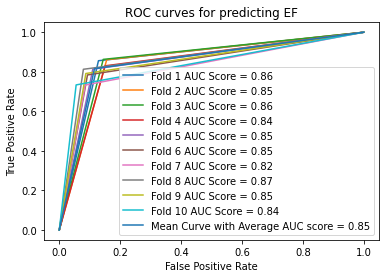

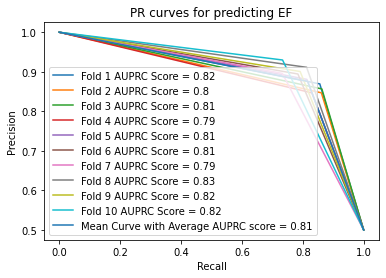

In [106]:
import warnings
warnings.filterwarnings("ignore")

model_params = {"input_dim":5,"num_outputs":1,"num_neurons": [100,50,10],"activation": "relu","hidden_layers": 3,
              "loss": "mean_squared_error","optimizer": keras.optimizers.Adam(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999),
                "output_activation": "sigmoid","metric": ["mse"]}

KF(df_svd_net_norm,num_splits=10,epochs=1000,batch_size=1000,
   main_title="SVD missing value imputation",
   model_params=model_params)

# Iterative Imputation Model

IIMP MISSING VALUE IMPUTATION
FOLD NUMBER 1
TRAIN: 7939 TEST: 883
Let's now compile the model
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_161 (Dense)            (None, 100)               600       
_________________________________________________________________
dense_162 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_163 (Dense)            (None, 10)                510       
_________________________________________________________________
dense_164 (Dense)            (None, 1)                 11        
Total params: 6,171
Trainable params: 6,171
Non-trainable params: 0
_________________________________________________________________
Counter({0: 5299, 1: 4789}) is the train counts of EF < 35%
Counter({0: 583, 1: 583}) is the test counts of EF < 35%
1166/1166 [===========================

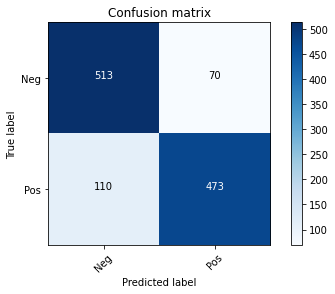

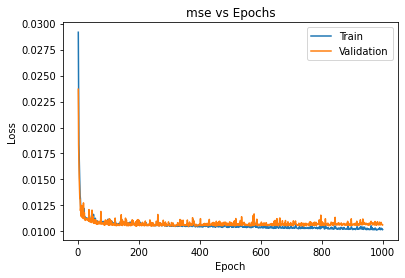



Time taken to run through 0.82 minutes
FOLD NUMBER 2
TRAIN: 7939 TEST: 883
Let's now compile the model
Counter({0: 5286, 1: 5056}) is the train counts of EF < 35%
Counter({0: 596, 1: 596}) is the test counts of EF < 35%
1192/1192 [==============================] - 0s 42us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  84.22818791946308 %
Recall score for this fold based on the limit EF < 35%:  83.7248322147651 %
Precision score for this fold based on the limit EF < 35%:  84.57627118644068 %
F1 score for this fold based on the limit EF < 35%:  84.14839797639124 %


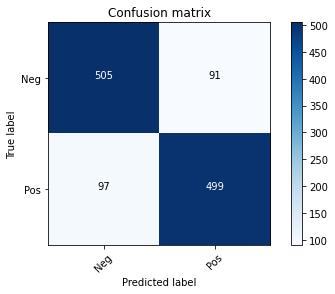

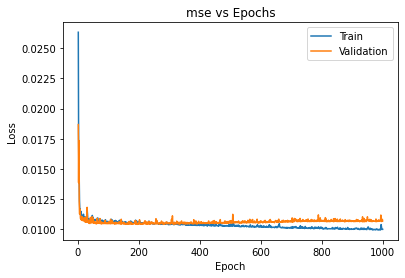



Time taken to run through 0.84 minutes
FOLD NUMBER 3
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({0: 5312, 1: 5050}) is the train counts of EF < 35%
Counter({0: 570, 1: 570}) is the test counts of EF < 35%
1140/1140 [==============================] - 0s 46us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  84.73684210526316 %
Recall score for this fold based on the limit EF < 35%:  81.57894736842105 %
Precision score for this fold based on the limit EF < 35%:  87.07865168539325 %
F1 score for this fold based on the limit EF < 35%:  84.23913043478261 %


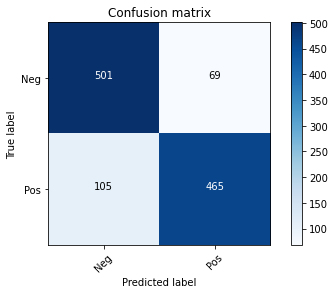

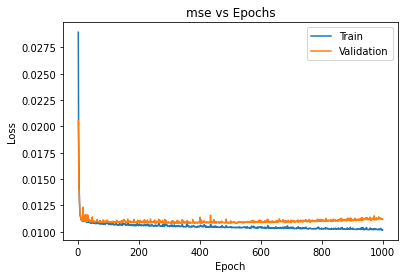



Time taken to run through 0.84 minutes
FOLD NUMBER 4
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({0: 5317, 1: 5219}) is the train counts of EF < 35%
Counter({0: 565, 1: 565}) is the test counts of EF < 35%
1130/1130 [==============================] - 0s 46us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  83.27433628318585 %
Recall score for this fold based on the limit EF < 35%:  78.76106194690266 %
Precision score for this fold based on the limit EF < 35%:  86.57587548638132 %
F1 score for this fold based on the limit EF < 35%:  82.483781278962 %


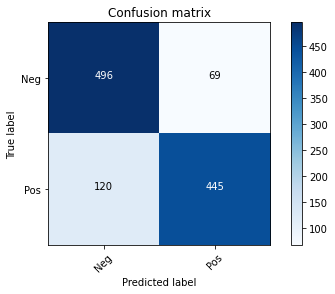

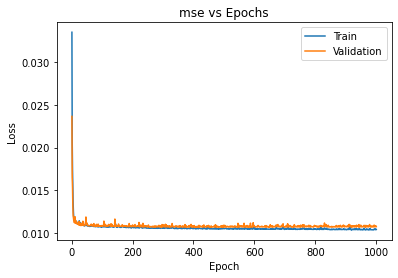



Time taken to run through 0.87 minutes
FOLD NUMBER 5
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({0: 5320, 1: 5310}) is the train counts of EF < 35%
Counter({0: 562, 1: 562}) is the test counts of EF < 35%
1124/1124 [==============================] - 0s 46us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  83.45195729537366 %
Recall score for this fold based on the limit EF < 35%:  74.19928825622776 %
Precision score for this fold based on the limit EF < 35%:  91.0480349344978 %
F1 score for this fold based on the limit EF < 35%:  81.76470588235294 %


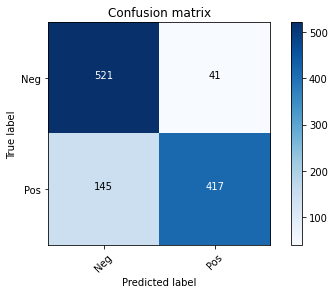

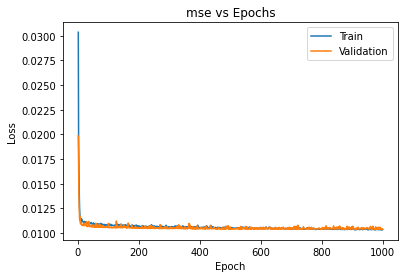



Time taken to run through 0.90 minutes
FOLD NUMBER 6
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({1: 5398, 0: 5277}) is the train counts of EF < 35%
Counter({1: 484, 0: 484}) is the test counts of EF < 35%
968/968 [==============================] - 0s 46us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  83.67768595041322 %
Recall score for this fold based on the limit EF < 35%:  74.79338842975206 %
Precision score for this fold based on the limit EF < 35%:  90.95477386934674 %
F1 score for this fold based on the limit EF < 35%:  82.08616780045352 %


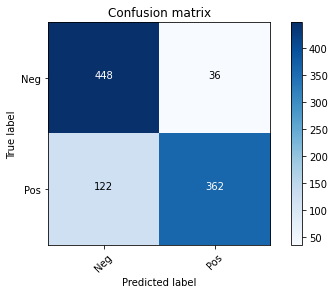

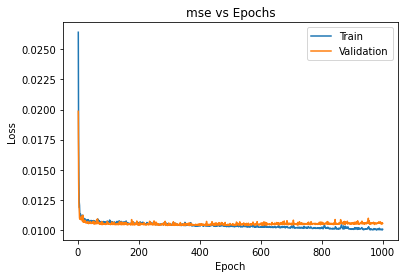



Time taken to run through 0.89 minutes
FOLD NUMBER 7
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({1: 5460, 0: 5271}) is the train counts of EF < 35%
Counter({1: 422, 0: 422}) is the test counts of EF < 35%
844/844 [==============================] - 0s 48us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  83.64928909952607 %
Recall score for this fold based on the limit EF < 35%:  76.77725118483413 %
Precision score for this fold based on the limit EF < 35%:  89.01098901098901 %
F1 score for this fold based on the limit EF < 35%:  82.44274809160305 %


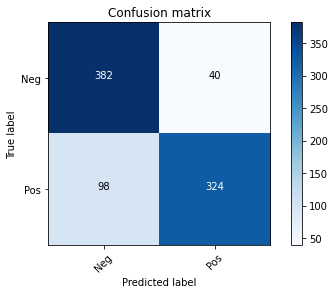

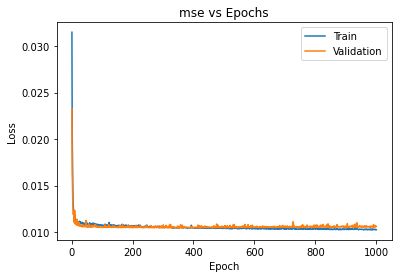



Time taken to run through 0.91 minutes
FOLD NUMBER 8
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({1: 5503, 0: 5305}) is the train counts of EF < 35%
Counter({0: 379, 1: 379}) is the test counts of EF < 35%
758/758 [==============================] - 0s 45us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  87.86279683377309 %
Recall score for this fold based on the limit EF < 35%:  86.01583113456465 %
Precision score for this fold based on the limit EF < 35%:  89.31506849315069 %
F1 score for this fold based on the limit EF < 35%:  87.63440860215054 %


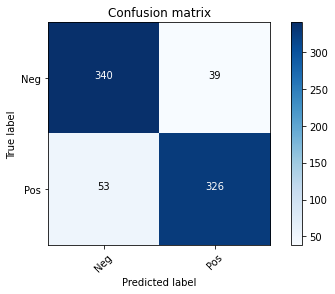

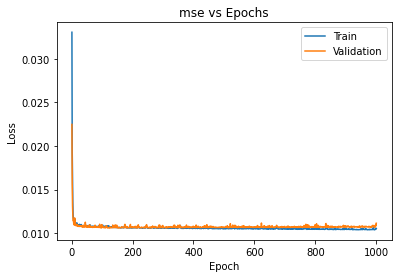



Time taken to run through 0.92 minutes
FOLD NUMBER 9
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({1: 5559, 0: 5280}) is the train counts of EF < 35%
Counter({1: 323, 0: 323}) is the test counts of EF < 35%
646/646 [==============================] - 0s 49us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  82.50773993808049 %
Recall score for this fold based on the limit EF < 35%:  73.9938080495356 %
Precision score for this fold based on the limit EF < 35%:  89.17910447761194 %
F1 score for this fold based on the limit EF < 35%:  80.87986463620982 %


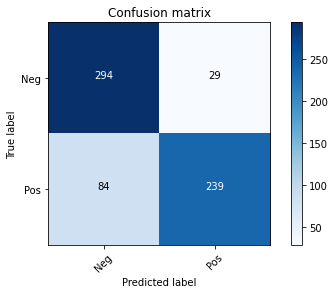

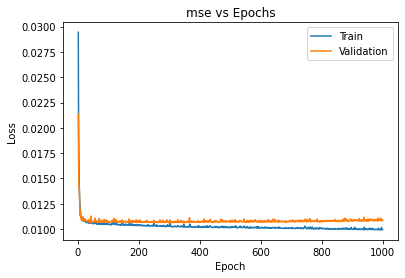



Time taken to run through 0.91 minutes
FOLD NUMBER 10
TRAIN: 7940 TEST: 882
Let's now compile the model
Counter({1: 5594, 0: 5271}) is the train counts of EF < 35%
Counter({0: 288, 1: 288}) is the test counts of EF < 35%
576/576 [==============================] - 0s 50us/step
Test mse from the model: 0.01
Raw accuracy calculated based on the limit EF < 35%:  85.76388888888889 %
Recall score for this fold based on the limit EF < 35%:  77.43055555555556 %
Precision score for this fold based on the limit EF < 35%:  92.91666666666667 %
F1 score for this fold based on the limit EF < 35%:  84.46969696969697 %


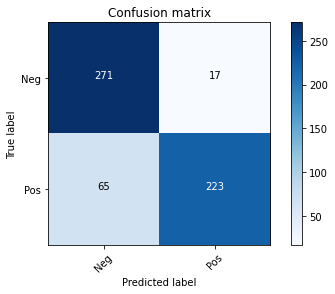

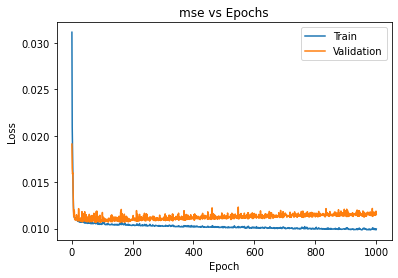



Time taken to run through 0.93 minutes
The mean mse across 10 folds is 0.01
The mean raw accuracy across 10 folds is 84.37%
The mean recall score across 10 folds is 78.84%
The mean precision score across 10 folds is 88.78%
The mean f1 score across 10 folds is 83.42%


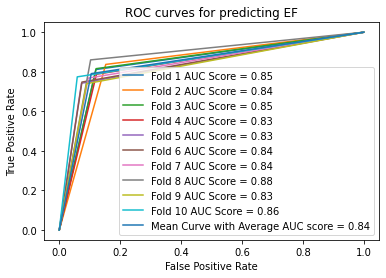

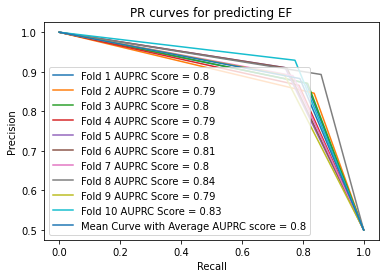

In [107]:
import warnings
warnings.filterwarnings("ignore")

model_params = {"input_dim":5,"num_outputs":1,"num_neurons": [100,50,10],"activation": "relu","hidden_layers": 3,
              "loss": "mean_squared_error","optimizer": keras.optimizers.Adam(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999),
                "output_activation": "sigmoid","metric": ["mse"]}

KF(df_iimp_net_norm,num_splits=10,epochs=1000,batch_size=1000,
   main_title="IIMP missing value imputation",
   model_params=model_params)

# Real EF vs Predicted EF

In [0]:
def EFCmp(df,df_test):
  model_params = {"input_dim":5,"num_outputs":1,"num_neurons": [100,50,10],"activation": "relu","hidden_layers": 3,
                "loss": "mean_squared_error","optimizer": keras.optimizers.Adam(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999),
                  "output_activation": "sigmoid","metric": ["mse"]}

  model = ANN(**model_params)

  features_picked = ["IVS d, 2D","LV d, 2D","LV s, 2D","RVSP (TR)","LA Vol A/L Volume"]
  output_feature = "Ejection_Fraction"

  X_all = df[features_picked].values
  y_all = df[output_feature].values
  y_all = y_all.reshape((-1,1))

  model.fit(X_all,y_all,batch_size = 1000,epochs = 10000,verbose = 0)

  X_test = df_test[features_picked].values
  y_test = df_test[output_feature].values
  y_test = y_test.reshape((-1,1))

  y_predicted = model.predict(X_test)
  return y_predicted

In [109]:
y_predicted = EFCmp(df_zero_net_norm,df_backup_net_norm)
y_expected = df_backup_net_norm["Ejection_Fraction"].values
y_expected = y_expected.reshape((-1,1))
for i in range(0,10):
  print(y_predicted[i],y_expected[i])

Let's now compile the model
[0.67] [0.74]
[0.62] [0.59]
[0.62] [0.66]
[0.72] [0.72]
[0.65] [0.64]
[0.53] [0.75]
[0.64] [0.69]
[0.53] [0.09]
[0.53] [0.2]
[0.24] [0.3]


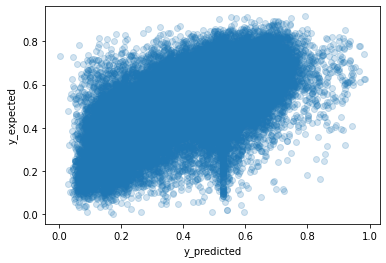

In [110]:
plt.scatter(y_predicted, y_expected,alpha=0.2)
plt.xlabel("y_predicted")
plt.ylabel("y_expected")
plt.show()

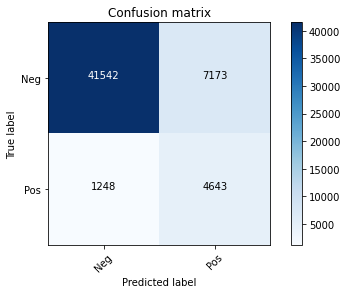

In [111]:
y_output_binarized = binarize_output(y_predicted)
y_test_binarized = binarize_output(y_expected)

#plot and visualize the confusion matrix
cnf_matrix = confusion_matrix(y_test_binarized,y_output_binarized)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["Neg","Pos"])

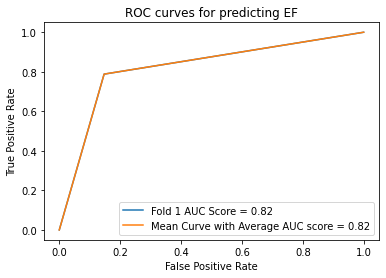

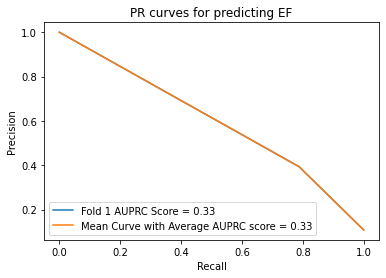

In [112]:
graphROC([y_test_binarized],[y_output_binarized],1)
graphPR([y_test_binarized],[y_output_binarized],1)

In [113]:
y_sorted = []
for i in range(10):
  temp = [y_predicted[j][0]*100 for j in range(len(y_expected)) if ((y_expected[j]<i*.1+.1) and (y_expected[j]>=i*.1))]
  y_sorted.append(temp)
  print("i = "+str(i))
  print(temp[:10])

i = 0
[52.90851593017578, 54.09842133522034, 4.993972182273865, 16.39232039451599, 18.638187646865845, 32.94695317745209, 6.535571813583374, 52.90851593017578, 16.842567920684814, 52.90851593017578]
i = 1
[52.90851593017578, 44.42190229892731, 21.6752290725708, 10.86912453174591, 12.92313039302826, 10.466137528419495, 43.677717447280884, 17.328816652297974, 12.43840754032135, 10.082346200942993]
i = 2
[19.87491250038147, 18.327373266220093, 25.853723287582397, 23.584863543510437, 18.24389398097992, 21.142607927322388, 57.64107704162598, 32.07037150859833, 54.32783365249634, 23.21118414402008]
i = 3
[23.609203100204468, 25.31687617301941, 38.735395669937134, 21.45533263683319, 52.90851593017578, 20.83585262298584, 11.345601081848145, 24.236133694648743, 9.25341248512268, 24.51193332672119]
i = 4
[22.37471342086792, 22.543343901634216, 14.960482716560364, 23.907029628753662, 12.63883113861084, 48.34067523479462, 24.804502725601196, 21.7434823513031, 29.111093282699585, 30.91195821762085]

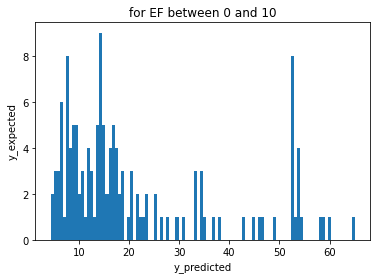

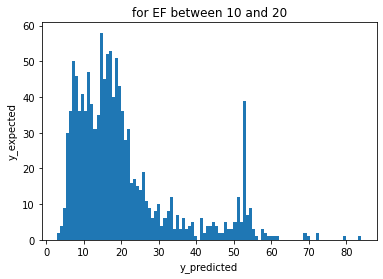

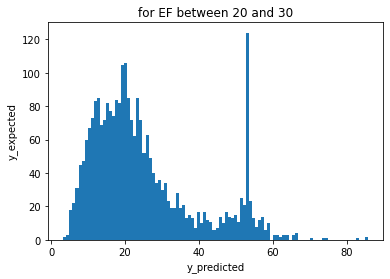

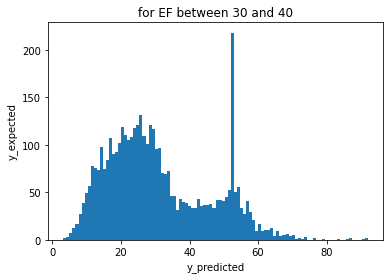

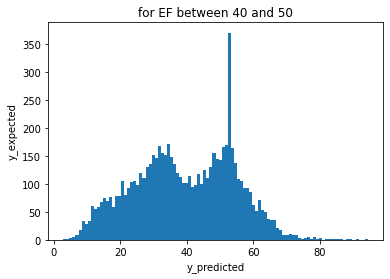

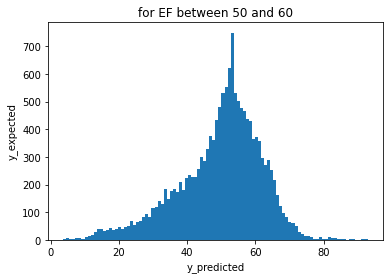

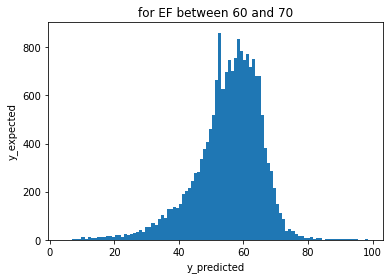

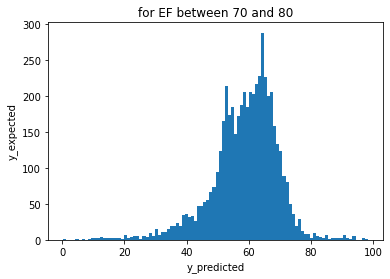

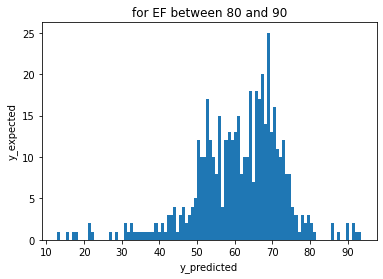

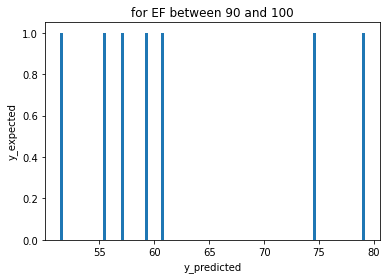

In [114]:
for i in range(10):
  plt.title("for EF between "+str(i*10)+" and "+str(i*10+10))
  plt.xlabel("y_predicted")
  plt.ylabel("y_expected")
  plt.hist(y_sorted[i],bins=100)
  plt.show()